In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import numpy as np
import pandas as pd
from src.PID import PID_utils
from scipy import stats
import copy

In [2]:
from matplotlib.lines import Line2D
import tikzplotlib
from sklearn.feature_selection import SelectFdr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

In [3]:
# fig_size = [6.4, 4.8], two_axes=True,
#                                 font_size=8
font_size = 25
params = {
#         'axes.labelsize': font_size,
#         'font.size': font_size,
        'font.serif' : 'Times',
        'font.sans-serif': ['Serif'],
        # 'text.usetex': True,
        # 'text.latex.preamble': [r'\usepackage[scaled]{helvet}',
        #                         r'\usepackage{sfmath}'],
#         'font.family': 'dejavuserif',
        'legend.fontsize': font_size,
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'axes.titlesize': font_size,
        'axes.labelsize': font_size,
#         'xlabel.labelsize' : 15,
#         'ylabel.labelsize' : 15
#         'axes.spines.right' : not two_axes,
#         'axes.spines.top' : not two_axes,
#         'figure.figsize': fig_size,
#         'legend.handlelength': 0.5
    }

matplotlib.rcParams.update(params)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
red = sns.color_palette("bwr",4).as_hex()[3]
blue = sns.color_palette("GnBu").as_hex()[4]
green = sns.color_palette("Set2").as_hex()[0]
orange = sns.color_palette("Set2").as_hex()[1]
purple = sns.color_palette("Set3").as_hex()[2]

colors = [red, blue, orange, green, purple]
sns.color_palette(colors)
sns.set_palette(colors)
palette = sns.color_palette(colors)

In [5]:
def pval_str(pval):
    if pval <= 0.0001:
        return "****"
    elif pval <= 0.001:
        return "***"
    elif pval <= 0.01:
        return "**"
    elif pval <= 0.05:
        return "*"
    else:
        return ""   

# Logic Gate Figures

In [6]:
def get_logic_seed_dicts(exp_fold):
    dict_list = {}
    conf_fold = os.listdir(exp_fold)
    conf_fold = sorted(sorted(conf_fold), key = len)
    for i in conf_fold:
        ckpt_fold = os.listdir(exp_fold + i)
        ckpt_fold = sorted(sorted(ckpt_fold), key = len)
        seed_dict = {}
        for j in range(0, 10):
            seed_dict[j]= PID_utils.load_dict(exp_fold + i + '/' + str(j) + '.json')
        dict_list[i] = seed_dict
           
    return dict_list

In [7]:
def get_nomask_dict(dict_list, dropout):
    nm_dict = {}
    for i in range(len(dropout)):
        nm_dict[str(dropout[i])] = dict_list[str(dropout[i])]
    return nm_dict

In [55]:
COPY_fold = 'PID/logic/COPY/hidden_10/'
XOR_fold = 'PID/logic/XOR/hidden_10/' 
COPY_dict_list = get_logic_seed_dicts(COPY_fold)
XOR_dict_list = get_logic_seed_dicts(XOR_fold)
dropout = [0.0, 0.1, 0.3, 0.5]
COPY_nm_dict = get_nomask_dict(COPY_dict_list, dropout)
XOR_nm_dict = get_nomask_dict(XOR_dict_list, dropout)

In [56]:
COPY_red = np.zeros((40, 2))
COPY_syn = np.zeros((40, 2))
XOR_red = np.zeros((40, 2))
XOR_syn = np.zeros((40, 2))
idx = 0
for i, d in enumerate(dropout):
    x = copy.deepcopy(d)
    for j in range(0,10):
        COPY_red[idx, 0] = x
        COPY_red[idx, 1] = COPY_nm_dict[str(d)][j]['k2_x2h_nimmi_red_avg'][0]
        COPY_syn[idx, 0] = x
        COPY_syn[idx, 1] = COPY_nm_dict[str(d)][j]['k2_x2h_nimmi_syn_avg'][0]
        XOR_red[idx, 0] = x
        XOR_red[idx, 1] = XOR_nm_dict[str(d)][j]['k2_x2h_nimmi_red_avg'][0]
        XOR_syn[idx, 0] = x
        XOR_syn[idx, 1] = XOR_nm_dict[str(d)][j]['k2_x2h_nimmi_syn_avg'][0]
        idx += 1

In [57]:
COPY_red_p = stats.ttest_ind(COPY_red[:,1][0:10], COPY_red[:,1][30:40])[1]
XOR_red_p = stats.ttest_ind(XOR_red[:,1][0:10], XOR_red[:,1][30:40])[1]
COPY_syn_p = stats.ttest_ind(COPY_syn[:,1][0:10], COPY_syn[:,1][30:40])[1]
XOR_syn_p = stats.ttest_ind(XOR_syn[:,1][0:10], XOR_syn[:,1][30:40])[1]
print(COPY_red_p, XOR_red_p, COPY_syn_p, XOR_syn_p)

0.01083289723598334 0.33056493127818276 0.0018943649784035183 0.33056493127818276


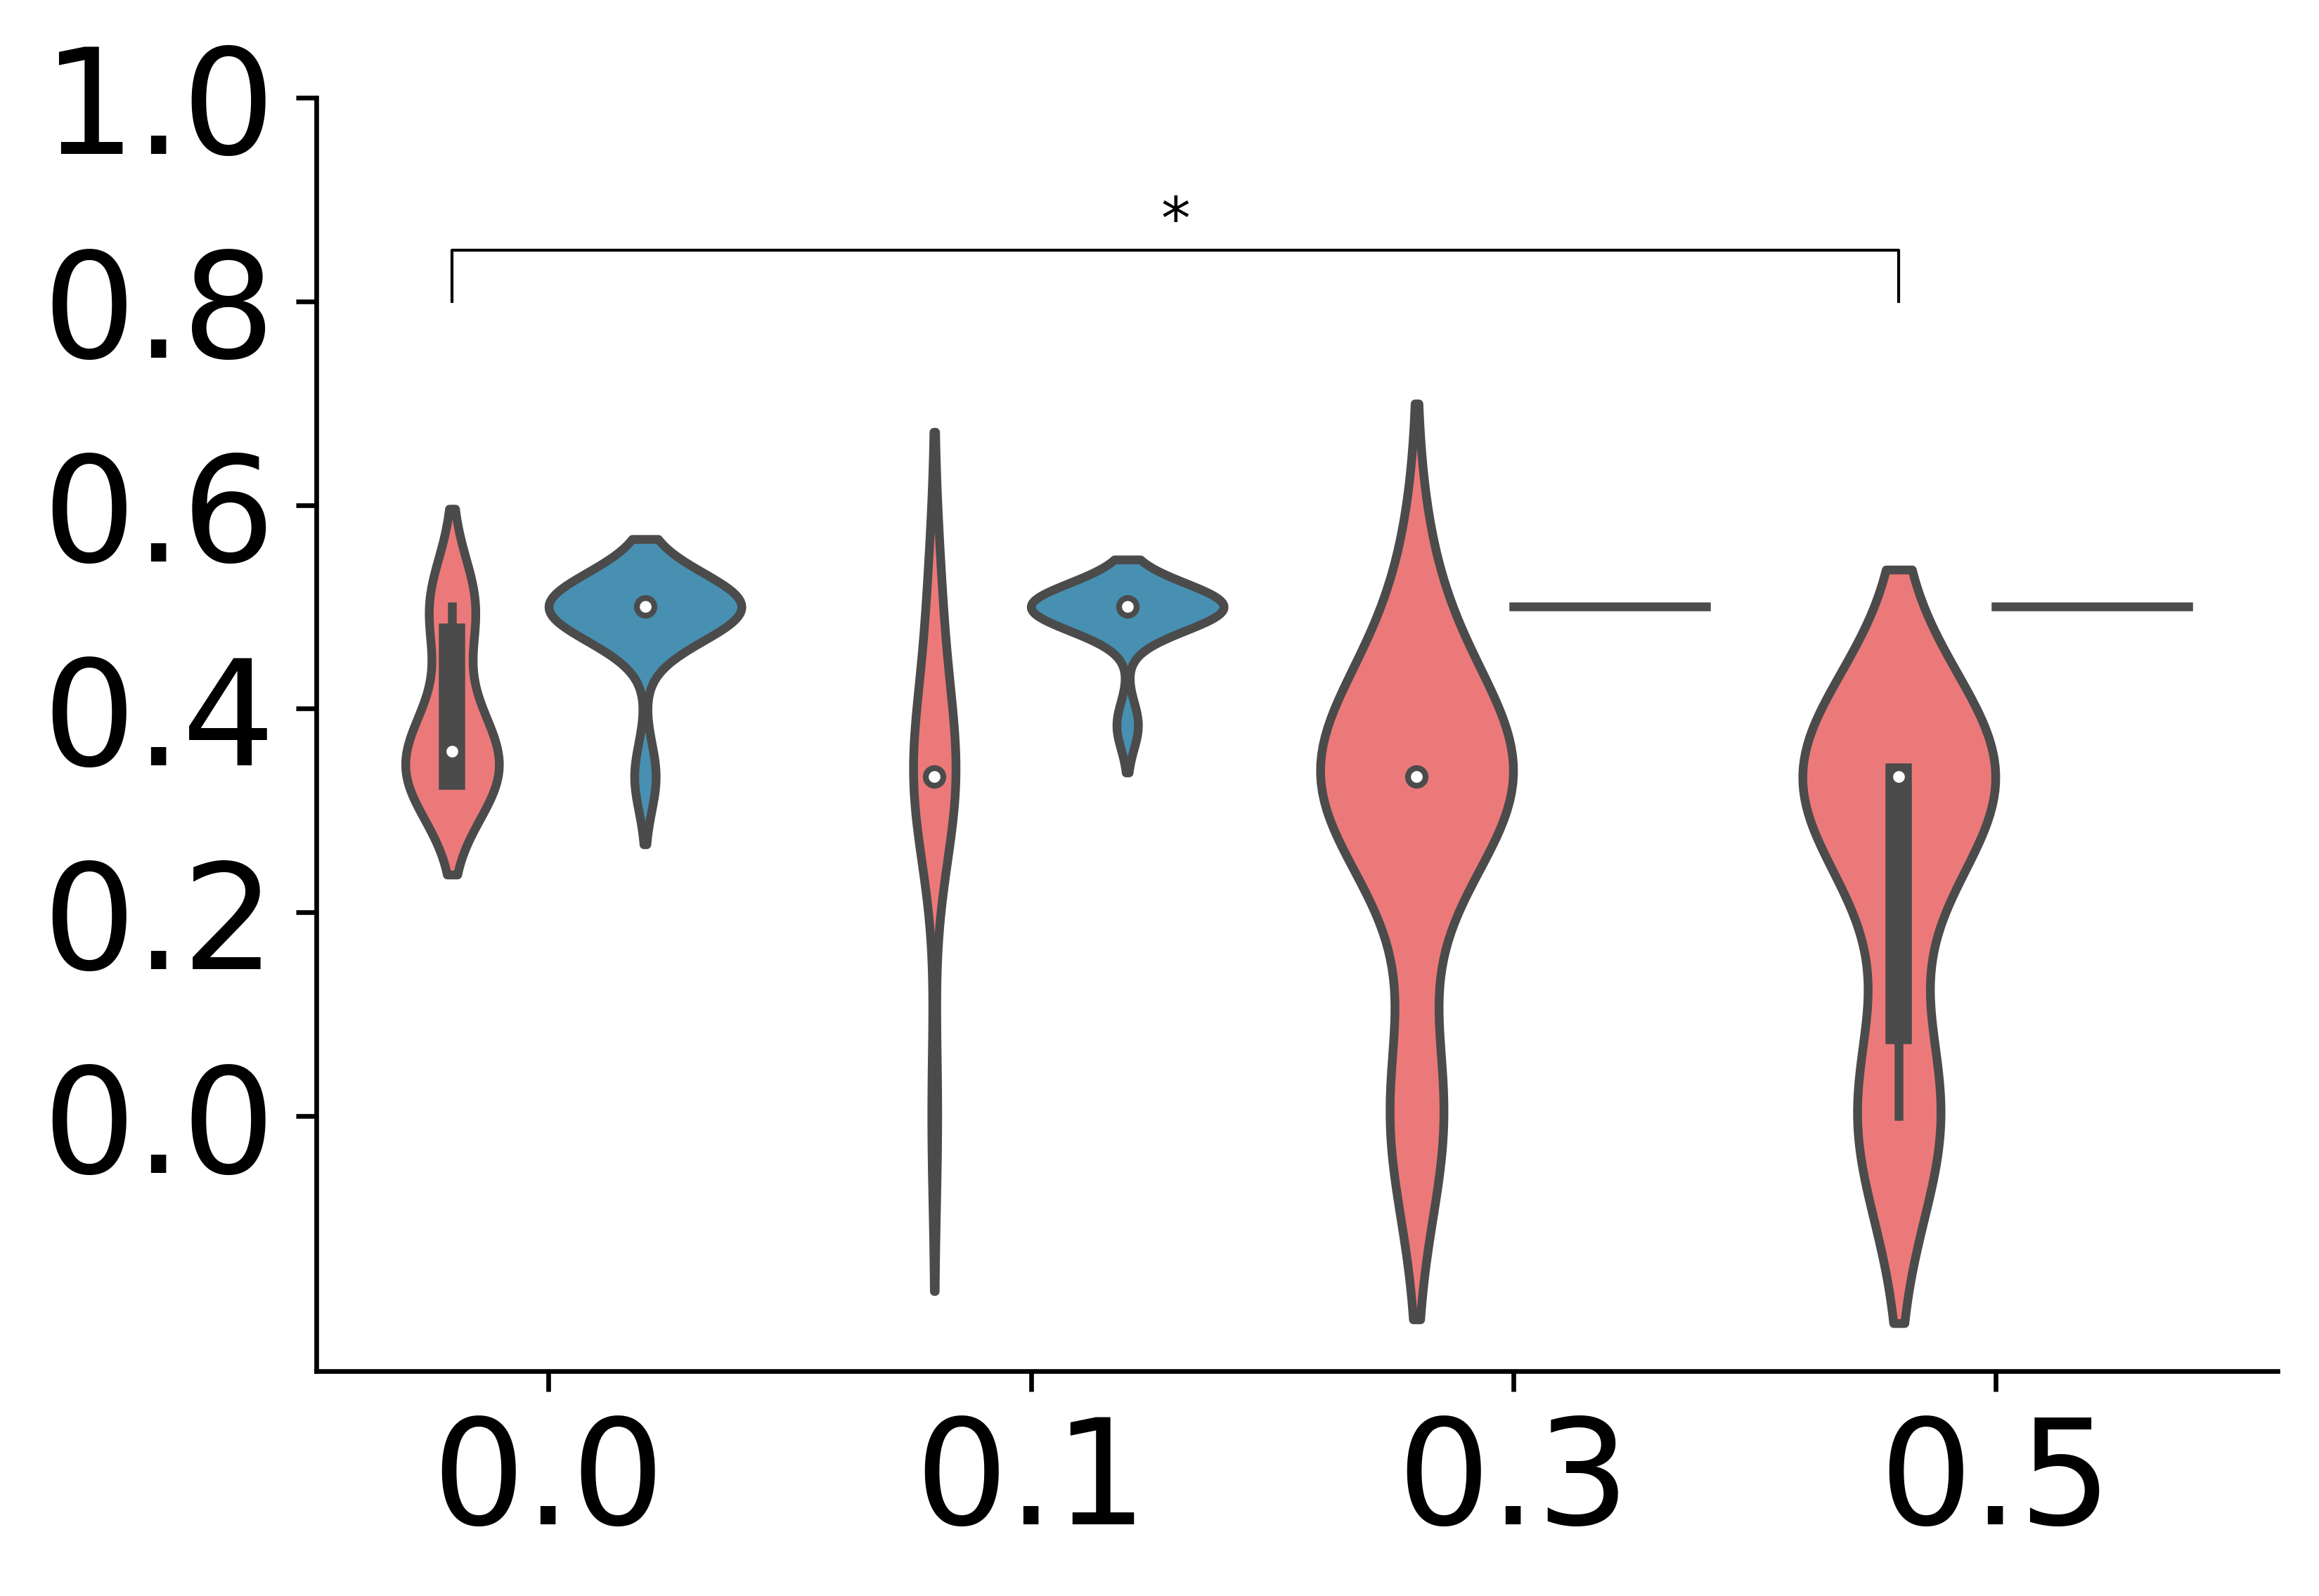

In [35]:
plt.figure(dpi=600)

df = pd.DataFrame({'Dropout': list(COPY_red[:,0]) + list(XOR_red[:,0]), 
                   'Redundancy': list(COPY_red[:,1]) + list(XOR_red[:,1]),
                   'Synergy' : list(COPY_syn[:,1]) + list(XOR_syn[:,1]) ,
                  'Task': ['COPY']*40 + ['XOR']*40})
sns.violinplot(data=df, x = 'Dropout', y = 'Redundancy', hue='Task', legend=False)
# plt.setp(axes, yticks=np.arange(-0.2, 1.2, 0.2))
plt.xlabel('')
x1, x2 = 0-0.2, 3-0.2   
y, h, col = df['Redundancy'].max() + 0.3, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
plt.text((x1+x2)*.5, y+h, pval_str(COPY_red_p), ha='center', va='bottom', color=col)
plt.ylim(-0.25, 1)
plt.yticks(np.arange(0.0, 1.2, 0.2))
plt.xlabel('')
plt.ylabel('')
plt.minorticks_off()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.legend([],[], frameon=False)
# plt.savefig('PaperFigures-Draft5/R2-Fig1.png', bbox_inches='tight', transparent=True)
plt.show()
# axes[0].legend(loc="upper left", bbox_to_anchor=(1,1), prop={'size': 20})

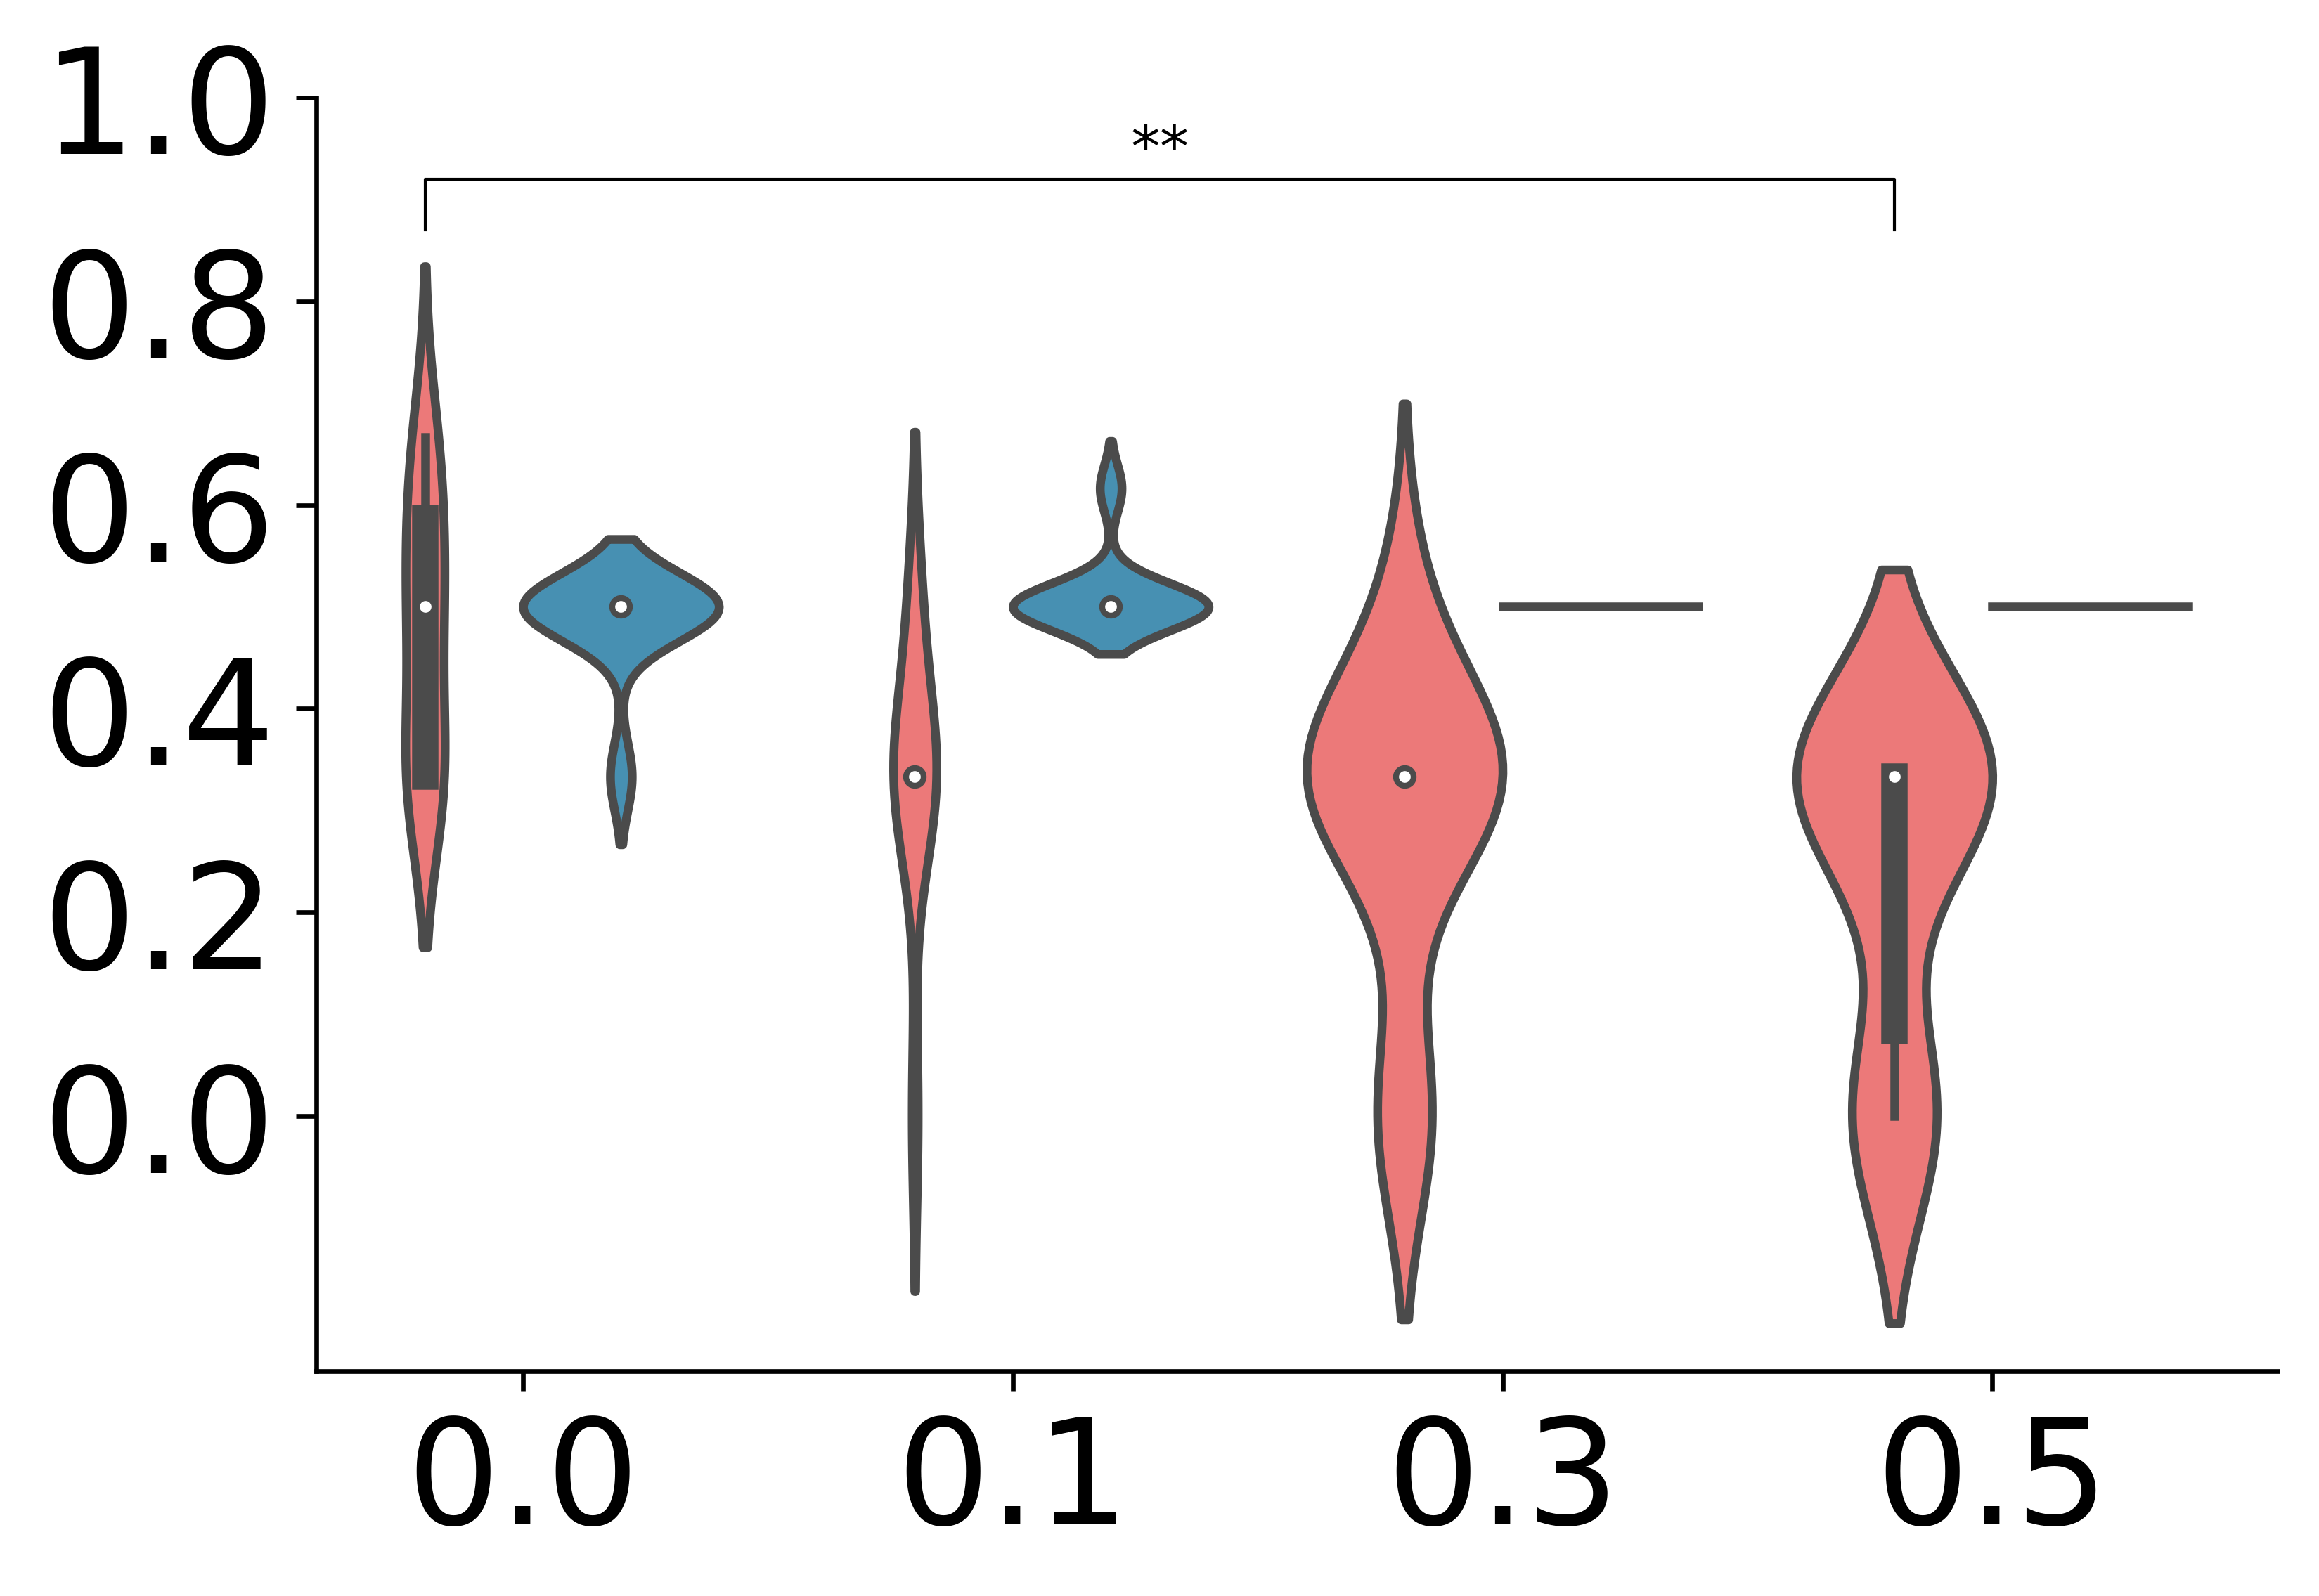

In [36]:
plt.figure(dpi=600)
sns.violinplot(data=df, x = 'Dropout', y = 'Synergy', hue='Task', legend=False)
x1, x2 = 0-0.2, 3-0.2   
y, h, col = df['Synergy'].max() + 0.3, 0.05, 'k'
y=0.87
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
plt.text((x1+x2)*.5, y+h, pval_str(COPY_syn_p), ha='center', va='bottom', color=col)
plt.ylim(-0.25, 1)
plt.yticks(np.arange(0.0, 1.2, 0.2))
plt.xlabel('')
plt.ylabel('')
plt.minorticks_off()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.legend([],[], frameon=False)
# plt.savefig('PaperFigures-Draft5/R2-Fig3.png', bbox_inches='tight', transparent=True)
plt.show()

In [58]:
COPY_lay0_red = np.zeros((40, 2))
COPY_lay1_red = np.zeros((40, 2))
COPY_lay2_red = np.zeros((40, 2))
XOR_lay0_red = np.zeros((40, 2))
XOR_lay1_red = np.zeros((40, 2))
XOR_lay2_red = np.zeros((40, 2))
idx = 0
for i, d in enumerate(dropout):
    x = copy.deepcopy(d)
    for j in range(0,10):
        COPY_lay0_red[idx, 0] = x
        COPY_lay0_red[idx, 1] = COPY_nm_dict[str(d)][j]['k2_x2h_nimmi_red_avg'][0]
        COPY_lay1_red[idx, 0] = x
        COPY_lay1_red[idx, 1] = COPY_nm_dict[str(d)][j]['k2_x2h_nimmi_red_avg'][1]
        COPY_lay2_red[idx, 0] = x
        COPY_lay2_red[idx, 1] = COPY_nm_dict[str(d)][j]['k2_x2h_nimmi_red_avg'][2]
        XOR_lay0_red[idx, 0] = x
        XOR_lay0_red[idx, 1] = XOR_nm_dict[str(d)][j]['k2_x2h_nimmi_red_avg'][0]
        XOR_lay1_red[idx, 0] = x
        XOR_lay1_red[idx, 1] = XOR_nm_dict[str(d)][j]['k2_x2h_nimmi_red_avg'][1]
        XOR_lay2_red[idx, 0] = x
        XOR_lay2_red[idx, 1] = XOR_nm_dict[str(d)][j]['k2_x2h_nimmi_red_avg'][2]
        idx += 1

In [59]:
COPY_lay0_syn = np.zeros((40, 2))
COPY_lay1_syn = np.zeros((40, 2))
COPY_lay2_syn = np.zeros((40, 2))
XOR_lay0_syn = np.zeros((40, 2))
XOR_lay1_syn = np.zeros((40, 2))
XOR_lay2_syn = np.zeros((40, 2))
idx = 0
for i, d in enumerate(dropout):
    x = copy.deepcopy(d)
    for j in range(0,10):
        COPY_lay0_syn[idx, 0] = x
        COPY_lay0_syn[idx, 1] = COPY_nm_dict[str(d)][j]['k2_x2h_nimmi_syn_avg'][0]
        COPY_lay1_syn[idx, 0] = x
        COPY_lay1_syn[idx, 1] = COPY_nm_dict[str(d)][j]['k2_x2h_nimmi_syn_avg'][1]
        COPY_lay2_syn[idx, 0] = x
        COPY_lay2_syn[idx, 1] = COPY_nm_dict[str(d)][j]['k2_x2h_nimmi_syn_avg'][2]
        XOR_lay0_syn[idx, 0] = x
        XOR_lay0_syn[idx, 1] = XOR_nm_dict[str(d)][j]['k2_x2h_nimmi_syn_avg'][0]
        XOR_lay1_syn[idx, 0] = x
        XOR_lay1_syn[idx, 1] = XOR_nm_dict[str(d)][j]['k2_x2h_nimmi_syn_avg'][1]
        XOR_lay2_syn[idx, 0] = x
        XOR_lay2_syn[idx, 1] = XOR_nm_dict[str(d)][j]['k2_x2h_nimmi_syn_avg'][2]
        idx += 1

In [60]:
COPY_lay1_p = stats.ttest_ind(COPY_lay1_red[:,1][0:10], COPY_lay1_red[:,1][30:40])[1]
COPY_lay2_p = stats.ttest_ind(COPY_lay2_red[:,1][0:10], COPY_lay2_red[:,1][30:40])[1]
XOR_lay1_p = stats.ttest_ind(XOR_lay1_red[:,1][0:10], XOR_lay1_red[:,1][30:40])[1]
XOR_lay2_p = stats.ttest_ind(XOR_lay2_red[:,1][0:10], XOR_lay2_red[:,1][30:40])[1]
print(COPY_lay1_p, COPY_lay2_p, XOR_lay1_p, XOR_lay2_p)

8.656567970531148e-06 7.873921556330627e-10 0.07648117721131427 0.00038901059420681176


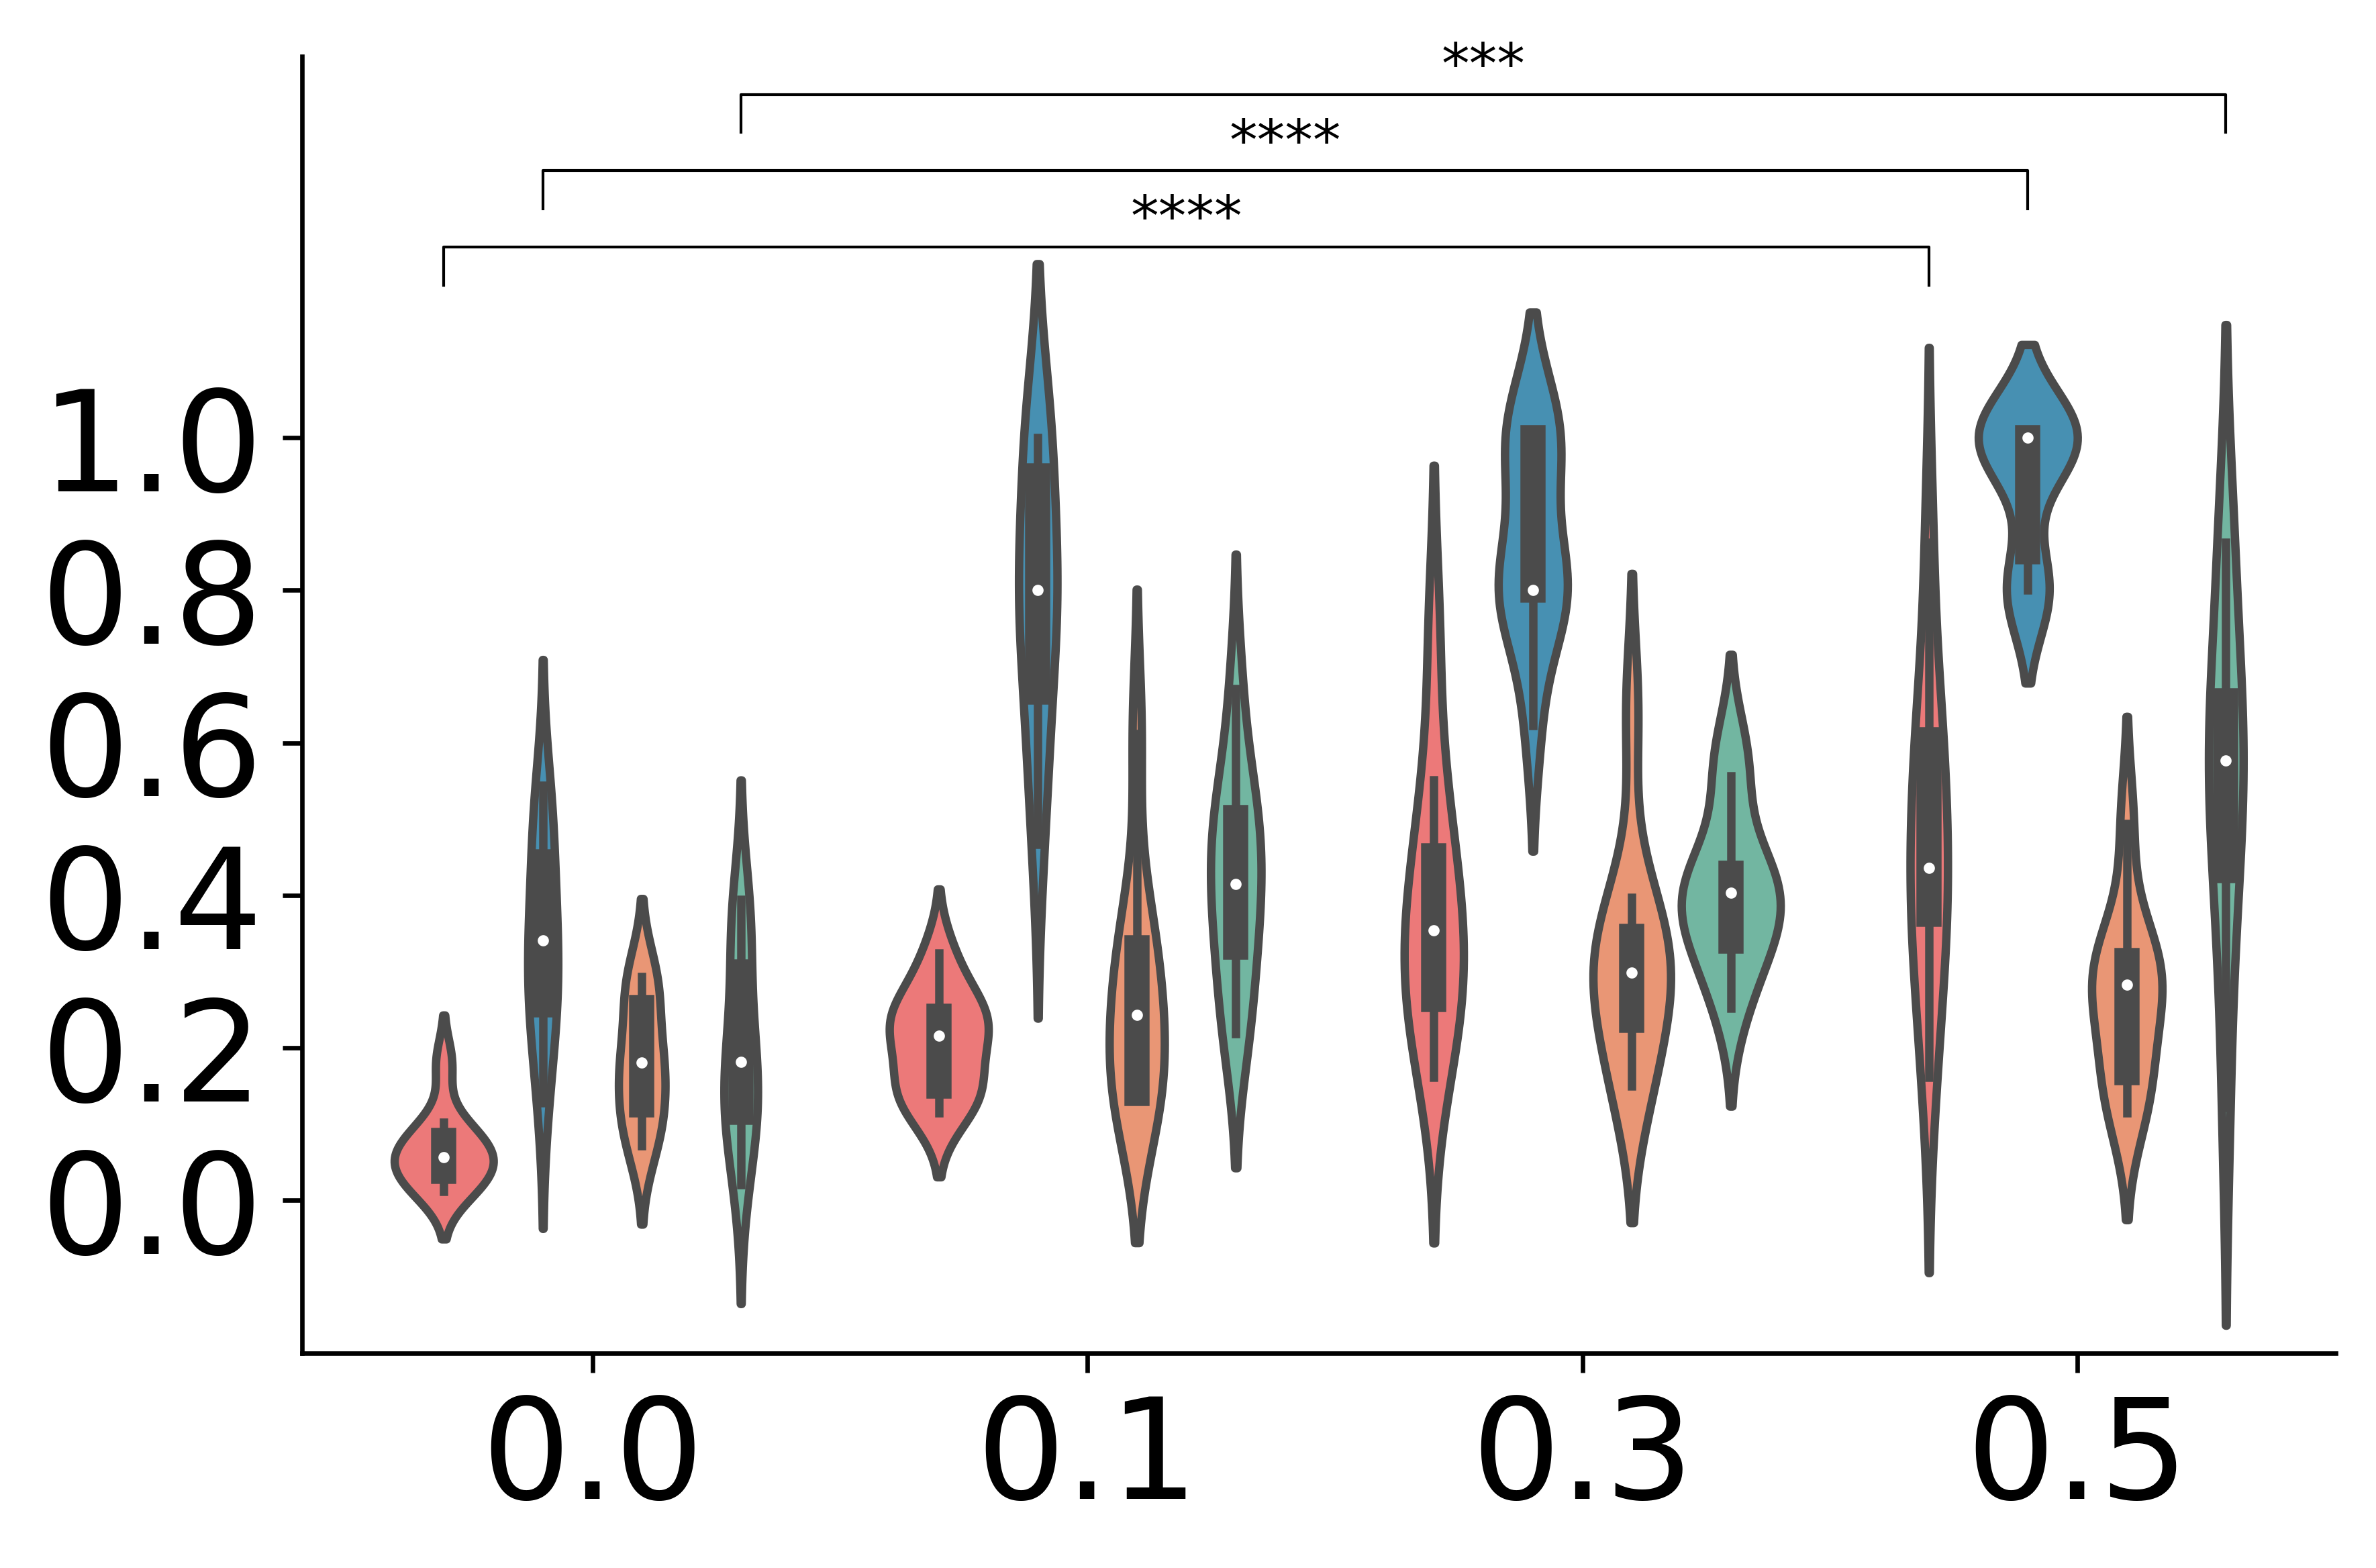

In [63]:
plt.figure(dpi=600)
df = pd.DataFrame({'Dropout': list(COPY_lay1_red[:,0]) + list(COPY_lay2_red[:,0]) + list(XOR_lay1_red[:,0]) + list(XOR_lay2_red[:,0]), 
                   'Redundancy': list(COPY_lay1_red[:,1]) + list(COPY_lay2_red[:,1]) + list(XOR_lay1_red[:,1]) + list(XOR_lay2_red[:,1]),
                  'Task': ['COPY Layer 1']*40 + ['COPY Layer 2']*40 + ['XOR Layer 1']*40 + ['XOR Layer 2']*40})
sns.violinplot(data=df, x='Dropout', y='Redundancy', hue='Task', legend=False)

height = 0.2
if pval_str(COPY_lay1_p) != '':
    x1, x2 = 0-0.3, 3-0.3  
    y, h, col = df['Redundancy'].max() + height, 0.05, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
    plt.text((x1+x2)*.5, y+h, pval_str(COPY_lay1_p), ha='center', va='bottom', color=col)
    height += 0.1

if pval_str(COPY_lay2_p) != '':    
    x1, x2 = 0-0.1, 3-0.1   
    y, h, col = df['Redundancy'].max() + height, 0.05, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
    plt.text((x1+x2)*.5, y+h, pval_str(COPY_lay2_p), ha='center', va='bottom', color=col)
    height += 0.1

if pval_str(XOR_lay1_p) != '':    
    x1, x2 = 0+0.1, 3+0.1   
    y, h, col = df['Redundancy'].max() + height, 0.05, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
    plt.text((x1+x2)*.5, y+h, pval_str(XOR_lay1_p), ha='center', va='bottom', color=col)
    height += 0.1
    
if pval_str(XOR_lay2_p) != '':
    x1, x2 = 0+0.3, 3+0.3  
    y, h, col = df['Redundancy'].max() + height, 0.05, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
    plt.text((x1+x2)*.5, y+h, pval_str(XOR_lay2_p), ha='center', va='bottom', color=col)
    height += 0.1

plt.minorticks_off()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.ylim(-0.2, 1.0 + height)
plt.yticks(np.arange(0.0, 1.2, 0.2))
plt.xlabel('')
plt.ylabel('')
plt.legend([],[], frameon=False)
plt.tight_layout()
# plt.savefig('PaperFigures-Draft5/R2-Fig2.pdf', bbox_inches='tight', transparent=True)
plt.show()

## Lesion

In [41]:
def get_logic_batch_dicts(exp_fold):
    # returns dict with names of files
    # exp_folder = 'computed_PID/XOR/2_sources/M_FF_2/'
    # requires ckpt names to be alphabetical within a configuration- always double check when running
    dict_list = {}
    conf_fold = os.listdir(exp_fold)
    conf_fold = sorted(sorted(conf_fold), key = len)
    for i in conf_fold:
        ckpt_fold = os.listdir(exp_fold + i)
        ckpt_fold = sorted(sorted(ckpt_fold), key = len)
        dict_list[i] = PID_utils.load_dict(exp_fold + i + '/batch.json')
           
    return dict_list

In [42]:
def get_mask_dict(dict_list, num_sources, base_str, dropout):
    mask_dict = {}
    for i in range(len(dropout)):
        mask_dict[str(dropout[i]) + '_0'] = dict_list[str(dropout[i])]
        for j in range(1, num_sources + 1):
            mask_dict[str(dropout[i]) + '_' + str(j)] = dict_list[str(dropout[i]) + base_str + str(j)]
    return mask_dict

In [43]:
def get_mask_avgs(max_dict, min_dict, num_sources, dropout):
    max_acc = []
    max_sem = []
    min_acc = []
    min_sem = []
    for i in range(0, num_sources + 1):
        max_acc.append(max_dict[str(dropout) + '_' + str(i)]['avg_reward_avg'])
        max_sem.append(max_dict[str(dropout) + '_' + str(i)]['avg_reward_sem'])
        min_acc.append(min_dict[str(dropout) + '_' + str(i)]['avg_reward_avg'])
        min_sem.append(min_dict[str(dropout) + '_' + str(i)]['avg_reward_sem'])
    return max_acc, max_sem, min_acc, min_sem

In [44]:
def pval2str(p_arr):
    str_arr = []
    for i in p_arr:
        if i <= 0.0001:
            str_arr.append("****")
        elif i <= 0.001:
            str_arr.append("***")
        elif i <= 0.01:
            str_arr.append("**")
        elif i <= 0.05:
            str_arr.append("*")
        else:
            str_arr.append("")
    return str_arr

In [45]:
COPY_fold = 'PID/logic/COPY/hidden_10/'
XOR_fold = 'PID/logic/XOR/hidden_10/'
COPY_dict_list = get_logic_batch_dicts(COPY_fold)
XOR_dict_list = get_logic_batch_dicts(XOR_fold)
dropout = [0.0]
COPY_nm_dict = get_nomask_dict(COPY_dict_list, dropout)
XOR_nm_dict = get_nomask_dict(XOR_dict_list, dropout)

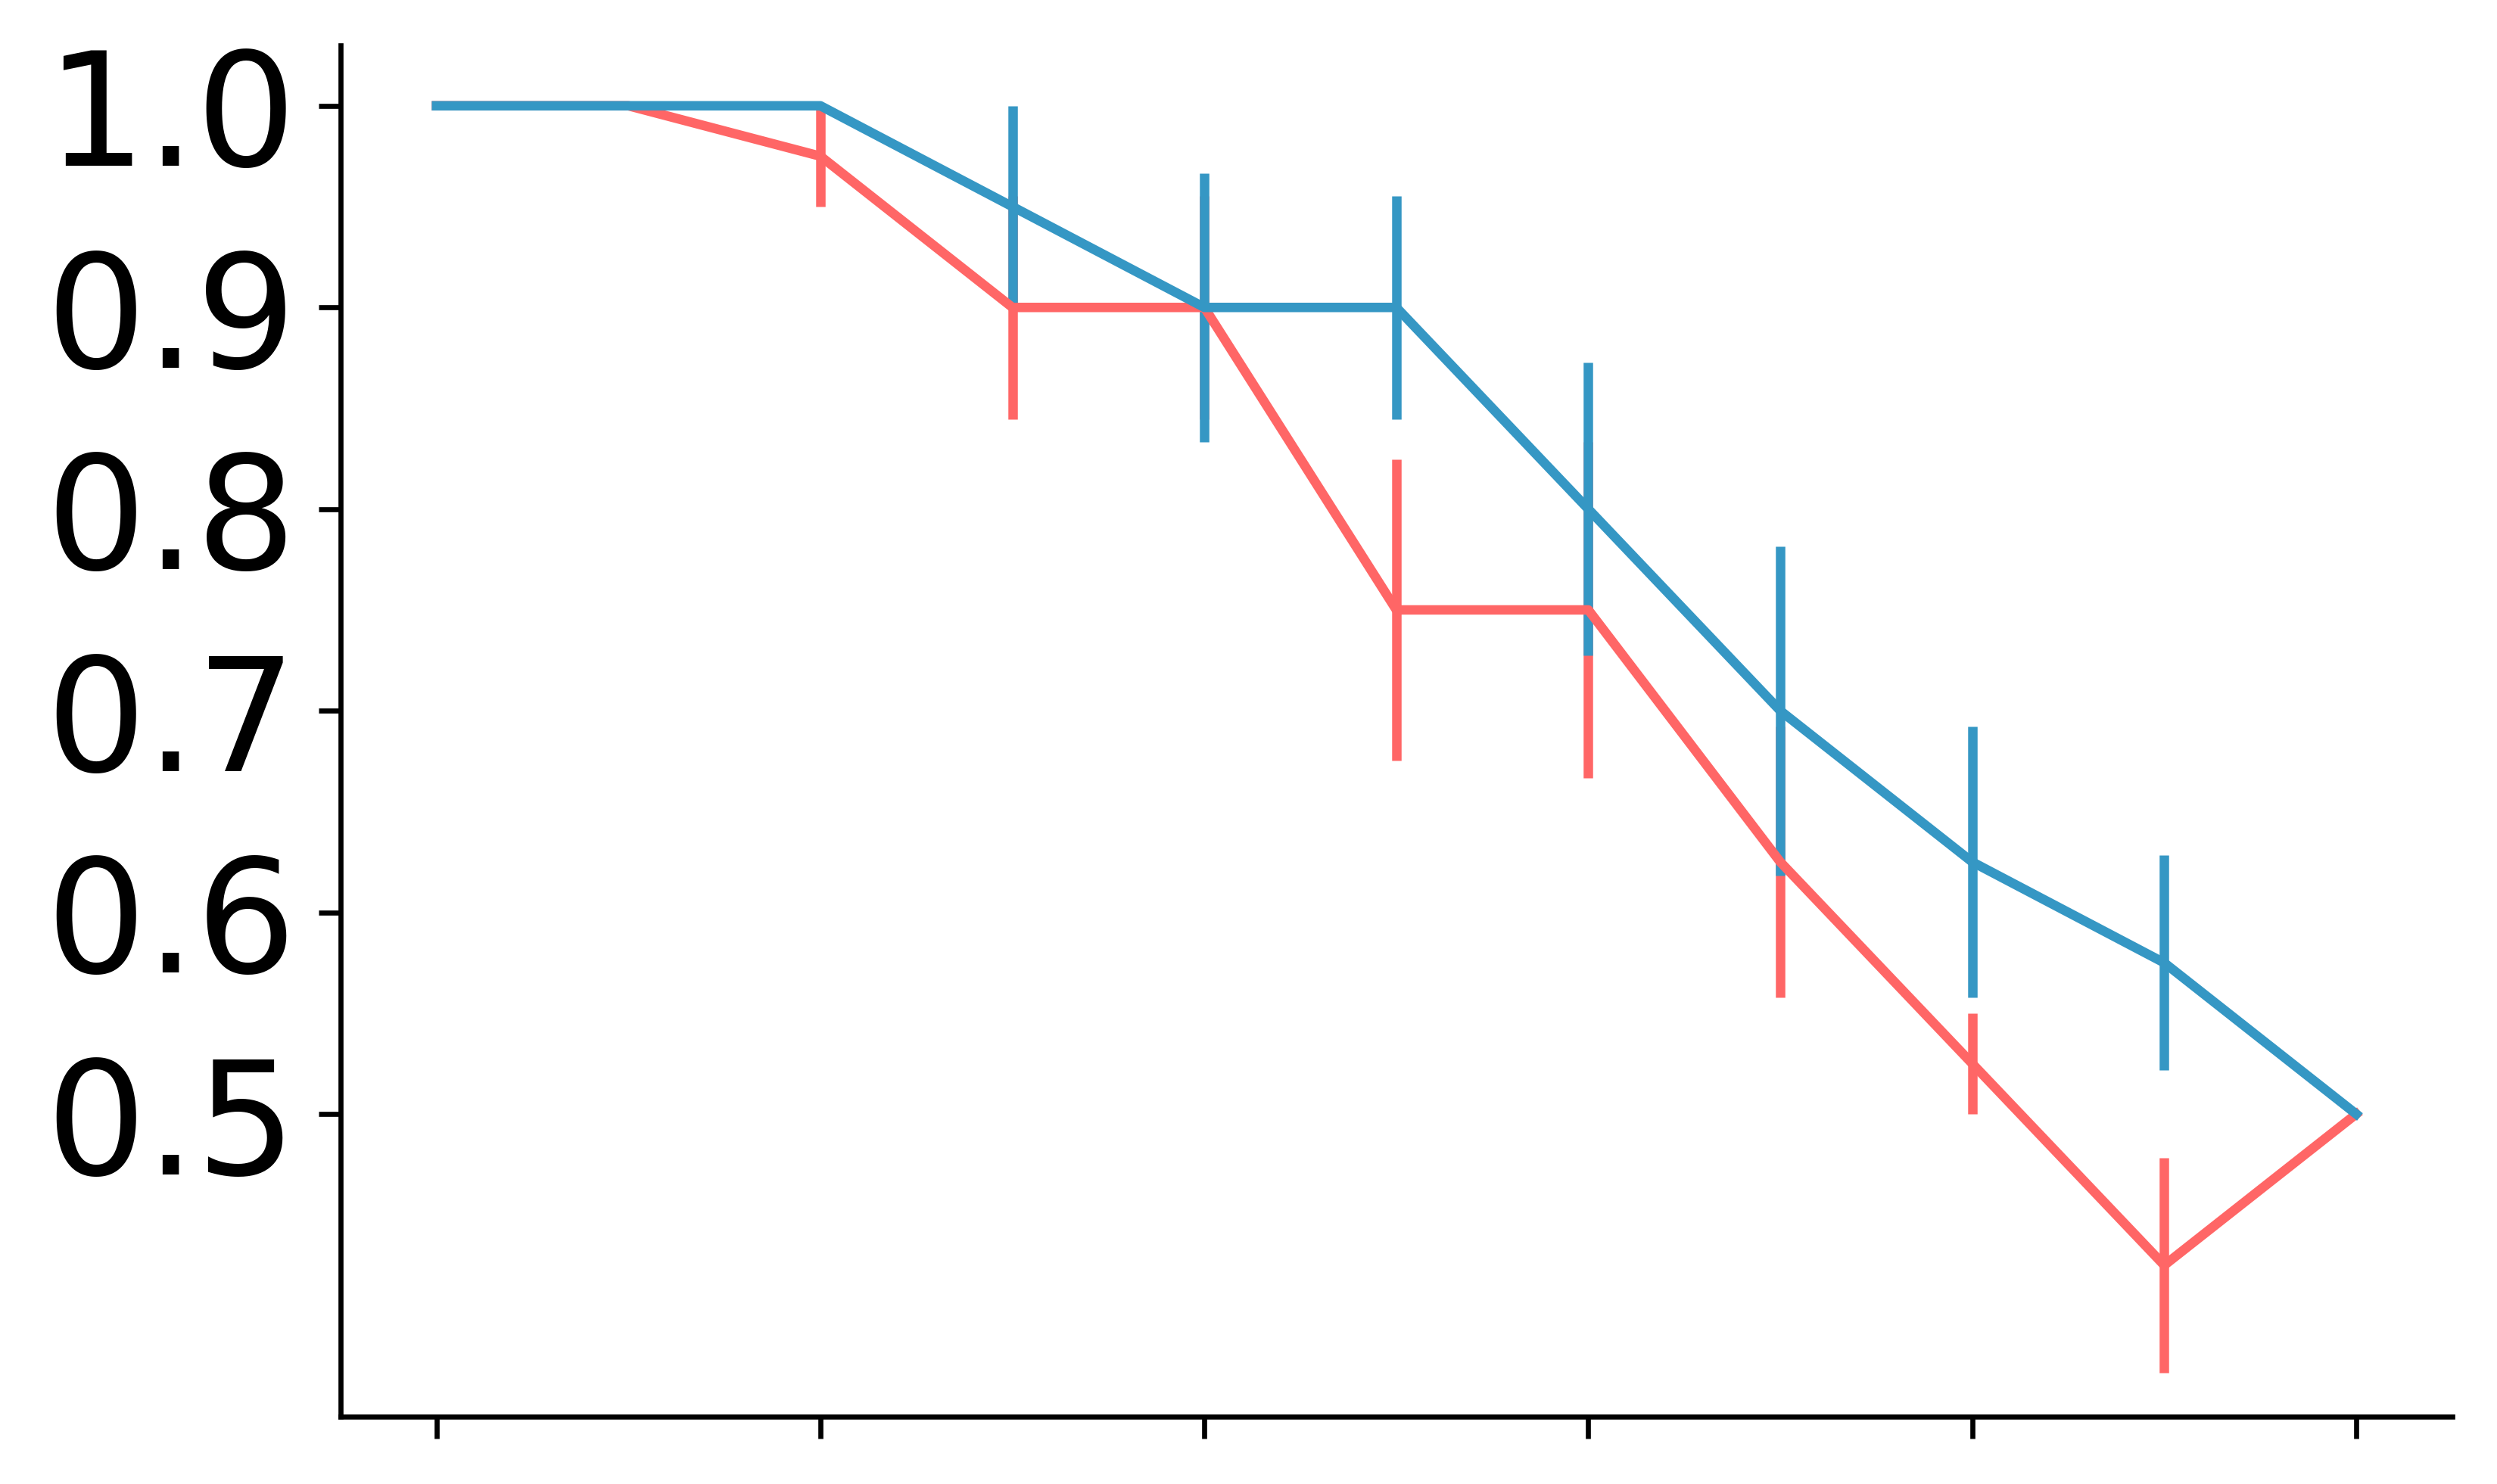

In [46]:
COPY_fold = 'PID/logic/COPY/hidden_10/'
dropout = [0.0, 0.5]
num_sources = 10
COPY_dict_list = get_logic_batch_dicts(COPY_fold)
max_dict = get_mask_dict(COPY_dict_list, num_sources, '_max_mask_nimmi', dropout)
min_dict = get_mask_dict(COPY_dict_list, num_sources, '_min_mask_nimmi', dropout)
max_acc, max_sem, min_acc, min_sem = get_mask_avgs(max_dict, min_dict, num_sources, dropout[0])
    
plt.figure(dpi=600)
x = range(0, len(max_acc))
y = max_acc
yerr = max_sem
plt.errorbar(x, y, yerr, label = 'By maximum synergy')
    
x = range(0, len(min_acc))
y = min_acc
yerr = min_sem
plt.errorbar(x, y, yerr, label = 'By minimum synergy')
plt.ylim(0.35, 1.03)
plt.yticks(np.arange(0.5,1.05,0.1))
plt.xticks(np.arange(0,12,2))
plt.minorticks_off()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticklabels([])
# plt.savefig('PaperFigures-Draft5/R3-Fig2.pdf', bbox_inches='tight', transparent=True)
plt.show()

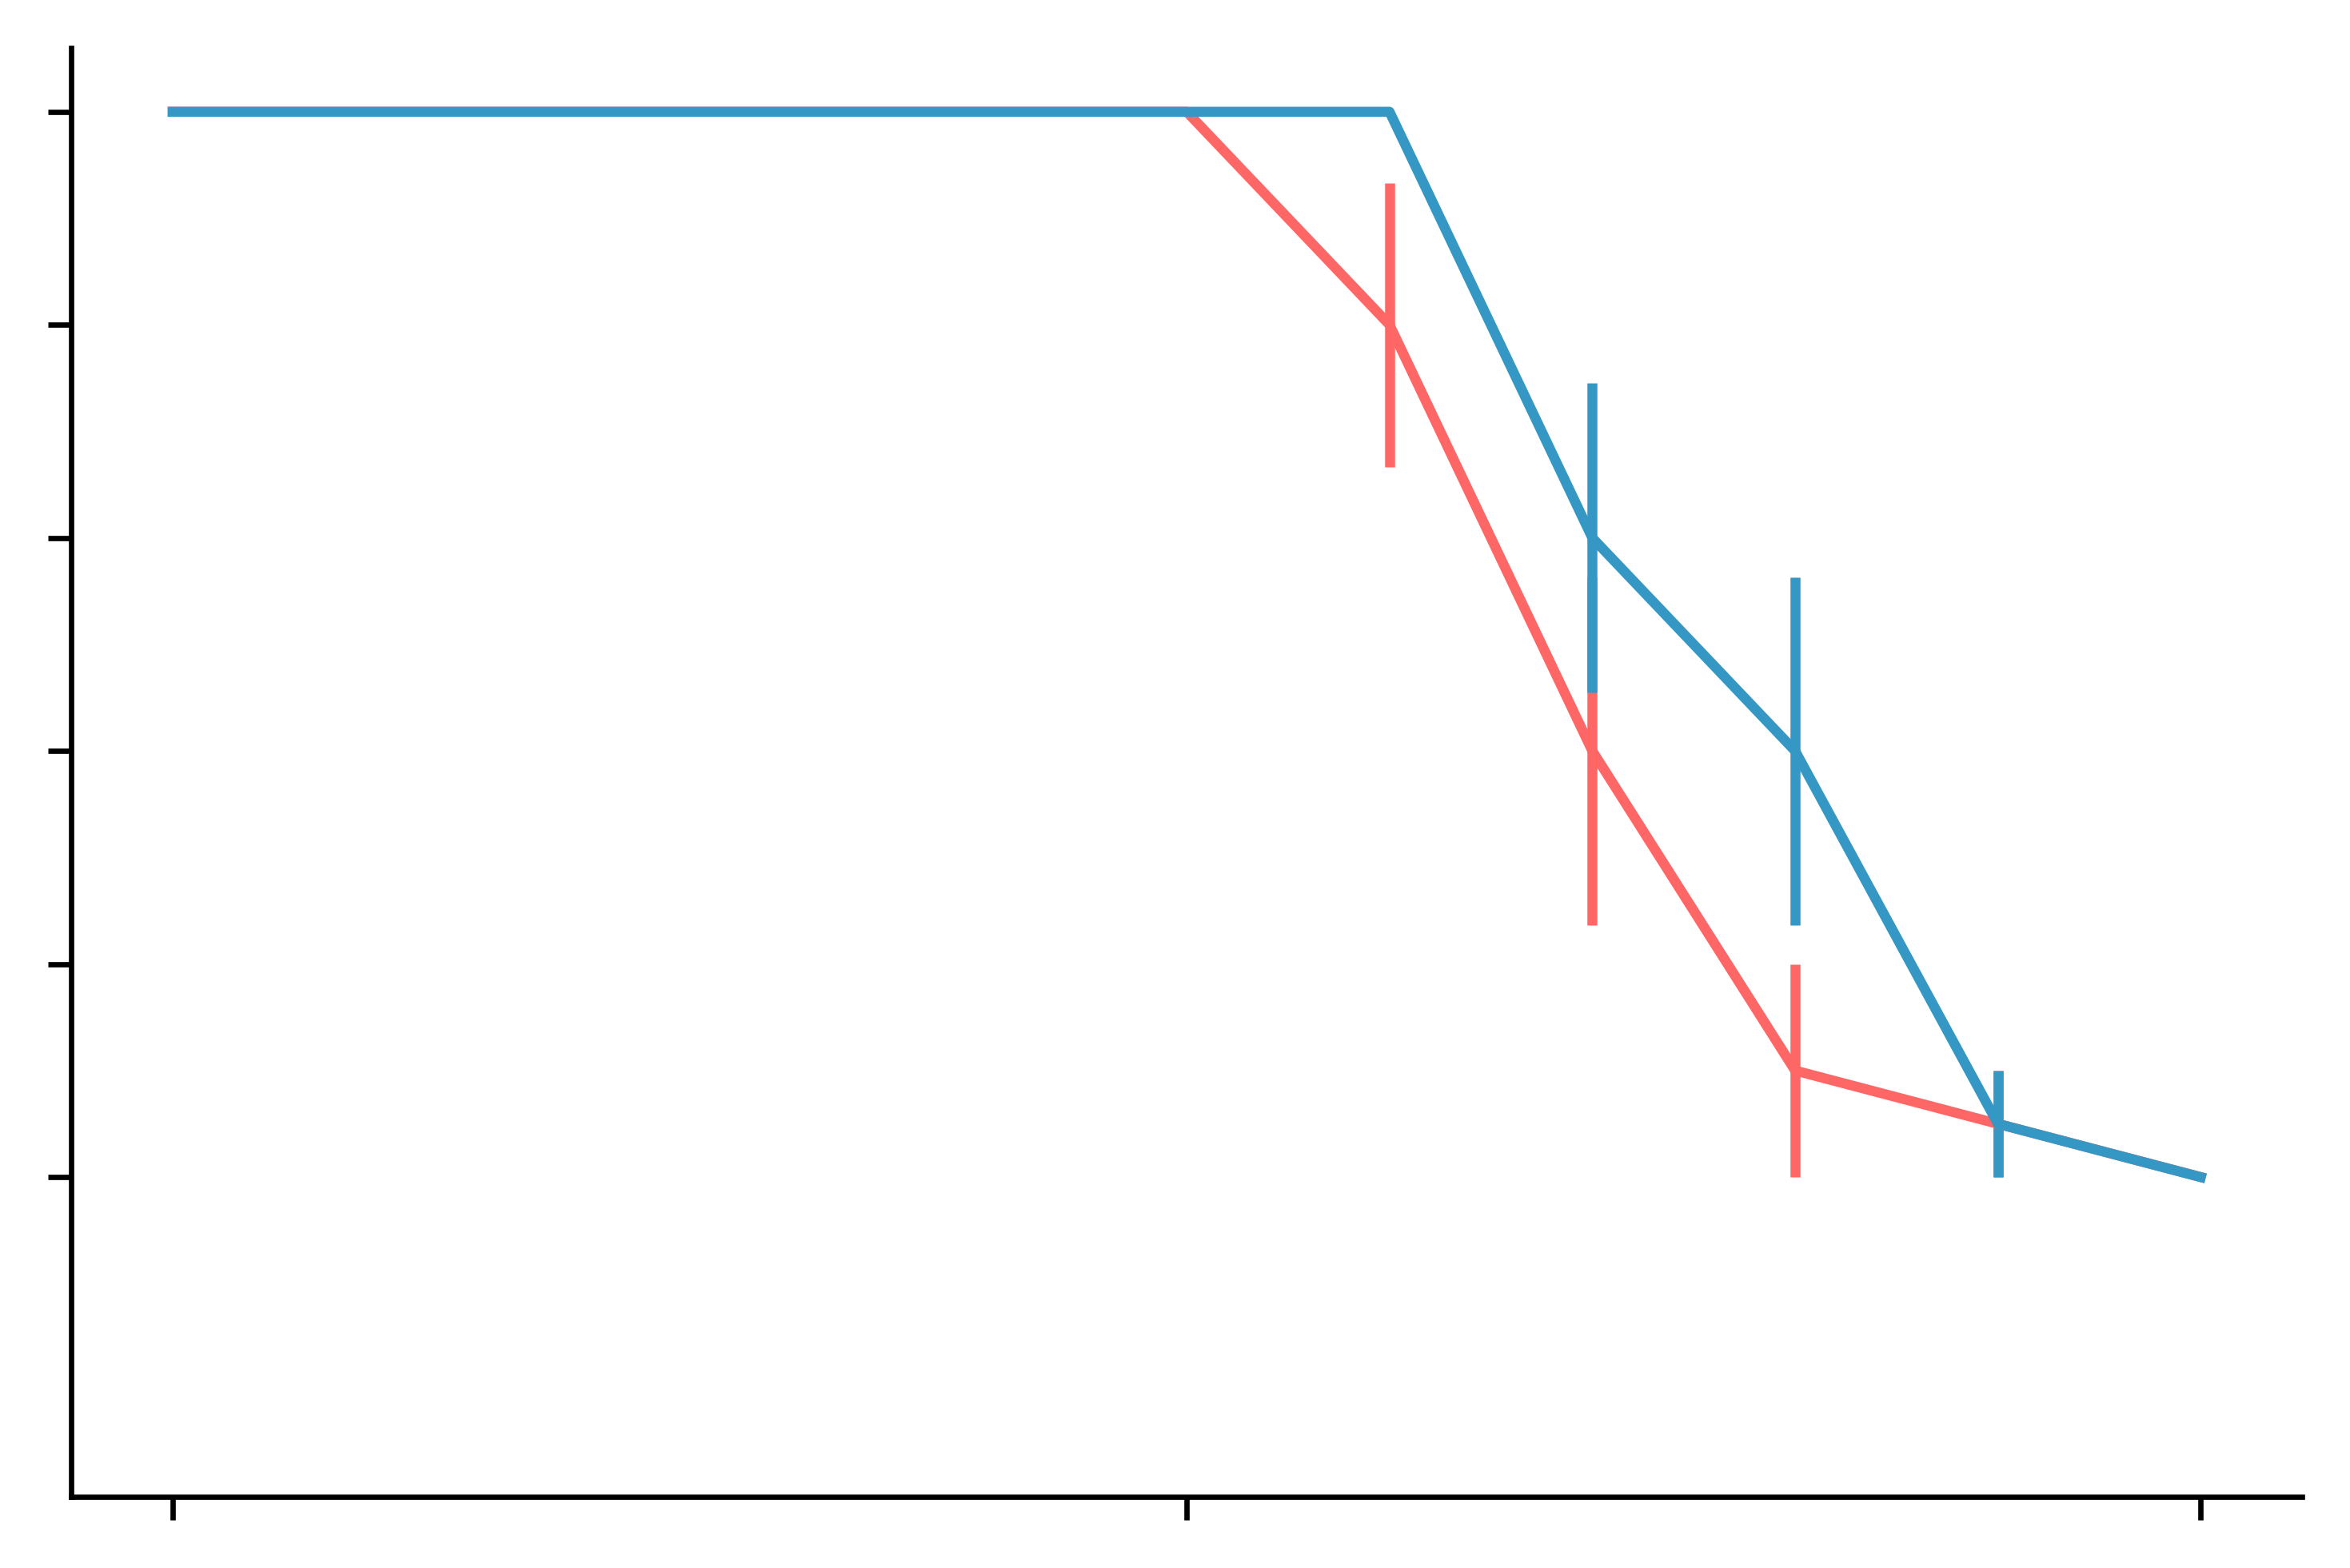

In [47]:
COPY_fold = 'PID/logic/COPY/hidden_10/'
dropout = [0.0, 0.5]
num_sources = 10
COPY_dict_list = get_logic_batch_dicts(COPY_fold)
max_dict = get_mask_dict(COPY_dict_list, num_sources, '_max_mask_nimmi', dropout)
min_dict = get_mask_dict(COPY_dict_list, num_sources, '_min_mask_nimmi', dropout)
max_acc, max_sem, min_acc, min_sem = get_mask_avgs(max_dict, min_dict, num_sources, dropout[1])
    
plt.figure(dpi=600)
x = range(0, len(max_acc))
y = max_acc
yerr = max_sem
plt.errorbar(x, y, yerr, label = 'By maximum synergy')
    
x = range(0, len(min_acc))
y = min_acc
yerr = min_sem
plt.errorbar(x, y, yerr, label = 'By minimum synergy')
plt.ylim(0.35, 1.03)
plt.yticks(np.arange(0.5,1.05,0.1))
plt.minorticks_off()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.gca().yaxis.set_ticklabels([])
plt.gca().xaxis.set_ticklabels([])
# plt.savefig('PaperFigures-Draft5/R3-Fig3.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [48]:
XOR_fold = 'PID/logic/XOR/hidden_10/'
XOR_dict_list = get_logic_seed_dicts(XOR_fold)
data1 = []
data2 = []
p_values = []
for i in range(1,11):
    key1 = '0.0_max_mask_nimmi' + str(i)
    key2 = '0.0_min_mask_nimmi' + str(i)
    for j in range(0,10):
        data1.append(XOR_dict_list[key1][j]['avg_reward'])
        data2.append(XOR_dict_list[key2][j]['avg_reward'])
    pval = stats.ttest_ind(data1, data2)[1]
    p_values.append(pval)
    data1 = []
    data2 = []    
print(p_values)
# FDR Correction
fdrcor = statsmodels.stats.multitest.fdrcorrection(p_values[:-1])
print(fdrcor)
fdr_str = pval2str(fdrcor[1])
print(pval2str(p_values))
print(fdr_str)

ind = []
for i in range(len(fdr_str)):
    if fdr_str[i] != '':
        ind.append(i)

[0.15095045218426711, 0.28776306790012546, 0.004885250129794853, 0.0053911564304565986, 0.07663758216165115, 0.16048047351545164, 0.015004964345069418, 0.11984009495520481, 0.33056493127818365, nan]
(array([False, False,  True,  True, False, False,  True, False, False]), array([0.20633204, 0.32373345, 0.0242602 , 0.0242602 , 0.17243456,
       0.20633204, 0.04501489, 0.20633204, 0.33056493]))
['', '', '**', '**', '', '', '*', '', '', '']
['', '', '*', '*', '', '', '*', '', '']


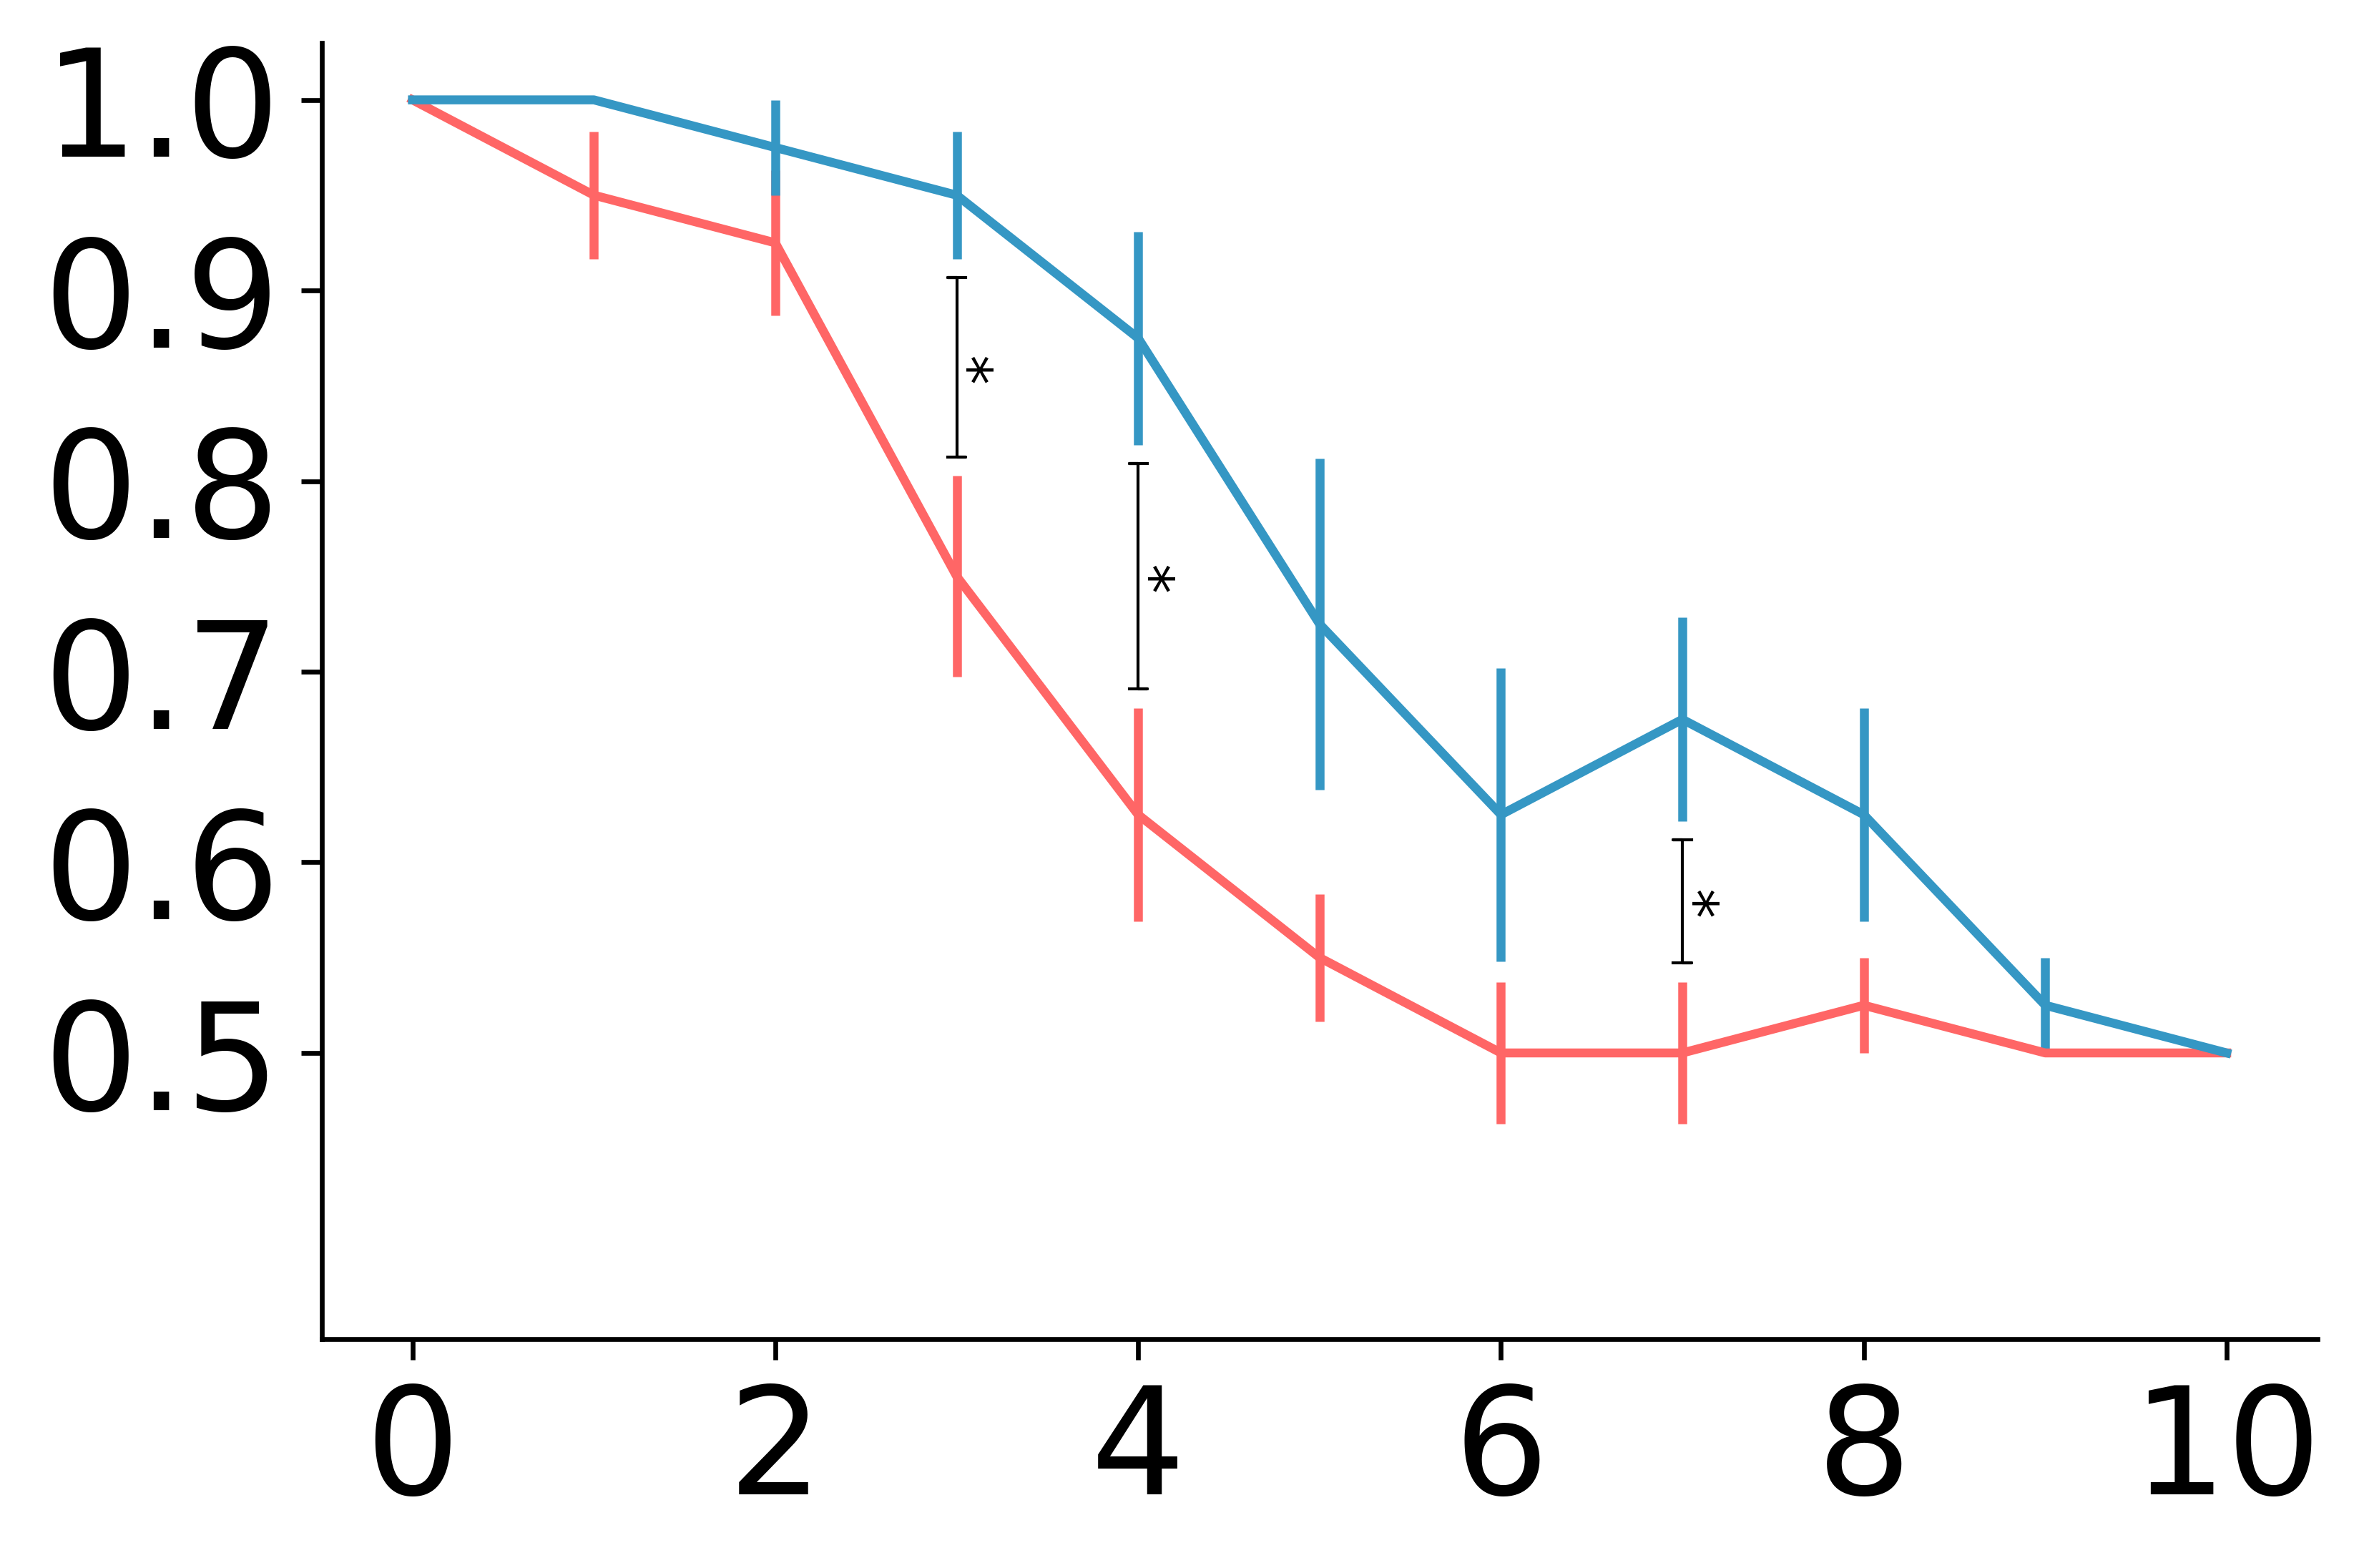

In [49]:
# WITH FDR CORRECTION
XOR_fold = 'PID/logic/XOR/hidden_10/'
dropout = [0.0, 0.5]
num_sources = 10
XOR_dict_list = get_logic_batch_dicts(XOR_fold)
max_dict = get_mask_dict(XOR_dict_list, num_sources, '_max_mask_nimmi', dropout)
min_dict = get_mask_dict(XOR_dict_list, num_sources, '_min_mask_nimmi', dropout)

max_acc, max_sem, min_acc, min_sem = get_mask_avgs(max_dict, min_dict, num_sources, dropout[0])
plt.figure(dpi=600)
plt.ylim(0.35, 1.03)
plt.yticks(np.arange(0.5,1.05,0.1))
x = range(0, len(max_acc))
plt.xticks(np.arange(0,12,2))
y = max_acc
yerr = max_sem
plt.errorbar(x, max_acc, max_sem, label = 'By maximum synergy')
y = min_acc
yerr = min_sem
plt.errorbar(x, min_acc, min_sem, label = 'By minimum synergy')

for i in ind:
    x1 = i + 1
    x2 = x1 - 0.05
    x3 = x1 + 0.05
    y = 0.5*((max_acc[x1] + max_sem[x1]) + (min_acc[x1] - min_sem[x1]))
    h, col = 0.04, 'k'
    h = (0.5*((min_acc[x1] - min_sem[x1])-(max_acc[x1] + max_sem[x1])))-0.01
    plt.plot([x2, x3, x1, x1, x2, x3], [y-h, y-h, y-h, y+h, y+h, y+h], lw=.5, c=col)
    plt.text((x1 + 0.2), (y), fdr_str[i], ha='center', va='center', color=col, rotation=90)

plt.minorticks_off()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
# plt.legend(prop={'size': 12}, loc="upper left", bbox_to_anchor=(1,1))
# plt.savefig('PaperFigures-Draft5/R3-Fig4.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [50]:
XOR_fold = 'PID/logic/XOR/hidden_10/'
XOR_dict_list = get_logic_seed_dicts(XOR_fold)
data1 = []
data2 = []
p_values = []
for i in range(1,11):
    key1 = '0.5_max_mask_nimmi' + str(i)
    key2 = '0.5_min_mask_nimmi' + str(i)
    for j in range(0,10):
        data1.append(XOR_dict_list[key1][j]['avg_reward'])
        data2.append(XOR_dict_list[key2][j]['avg_reward'])
    pval = stats.ttest_ind(data1, data2)[1]
    p_values.append(pval)
    data1 = []
    data2 = []    
print(p_values)
# FDR Correction
fdrcor = statsmodels.stats.multitest.fdrcorrection(p_values[1:-1])
print(fdrcor)
fdr_str = pval2str(fdrcor[1])
print(pval2str(p_values))
print(fdr_str)

ind = []
for i in range(len(fdr_str)):
    if fdr_str[i] != '':
        ind.append(i)

[0.33056493127818365, 0.15095045218426711, 0.001735429589931765, 0.004441318115737679, 4.3150405423804004e-05, 0.0004016101132767227, 7.792198564854122e-06, 0.004164161401613928, 0.15095045218426711, nan]
(array([False,  True,  True,  True,  True,  True,  True, False]), array([1.50950452e-01, 3.47085918e-03, 5.92175749e-03, 1.72601622e-04,
       1.07096030e-03, 6.23375885e-05, 5.92175749e-03, 1.50950452e-01]))
['', '', '**', '**', '****', '***', '****', '**', '', '']
['', '**', '**', '***', '**', '****', '**', '']


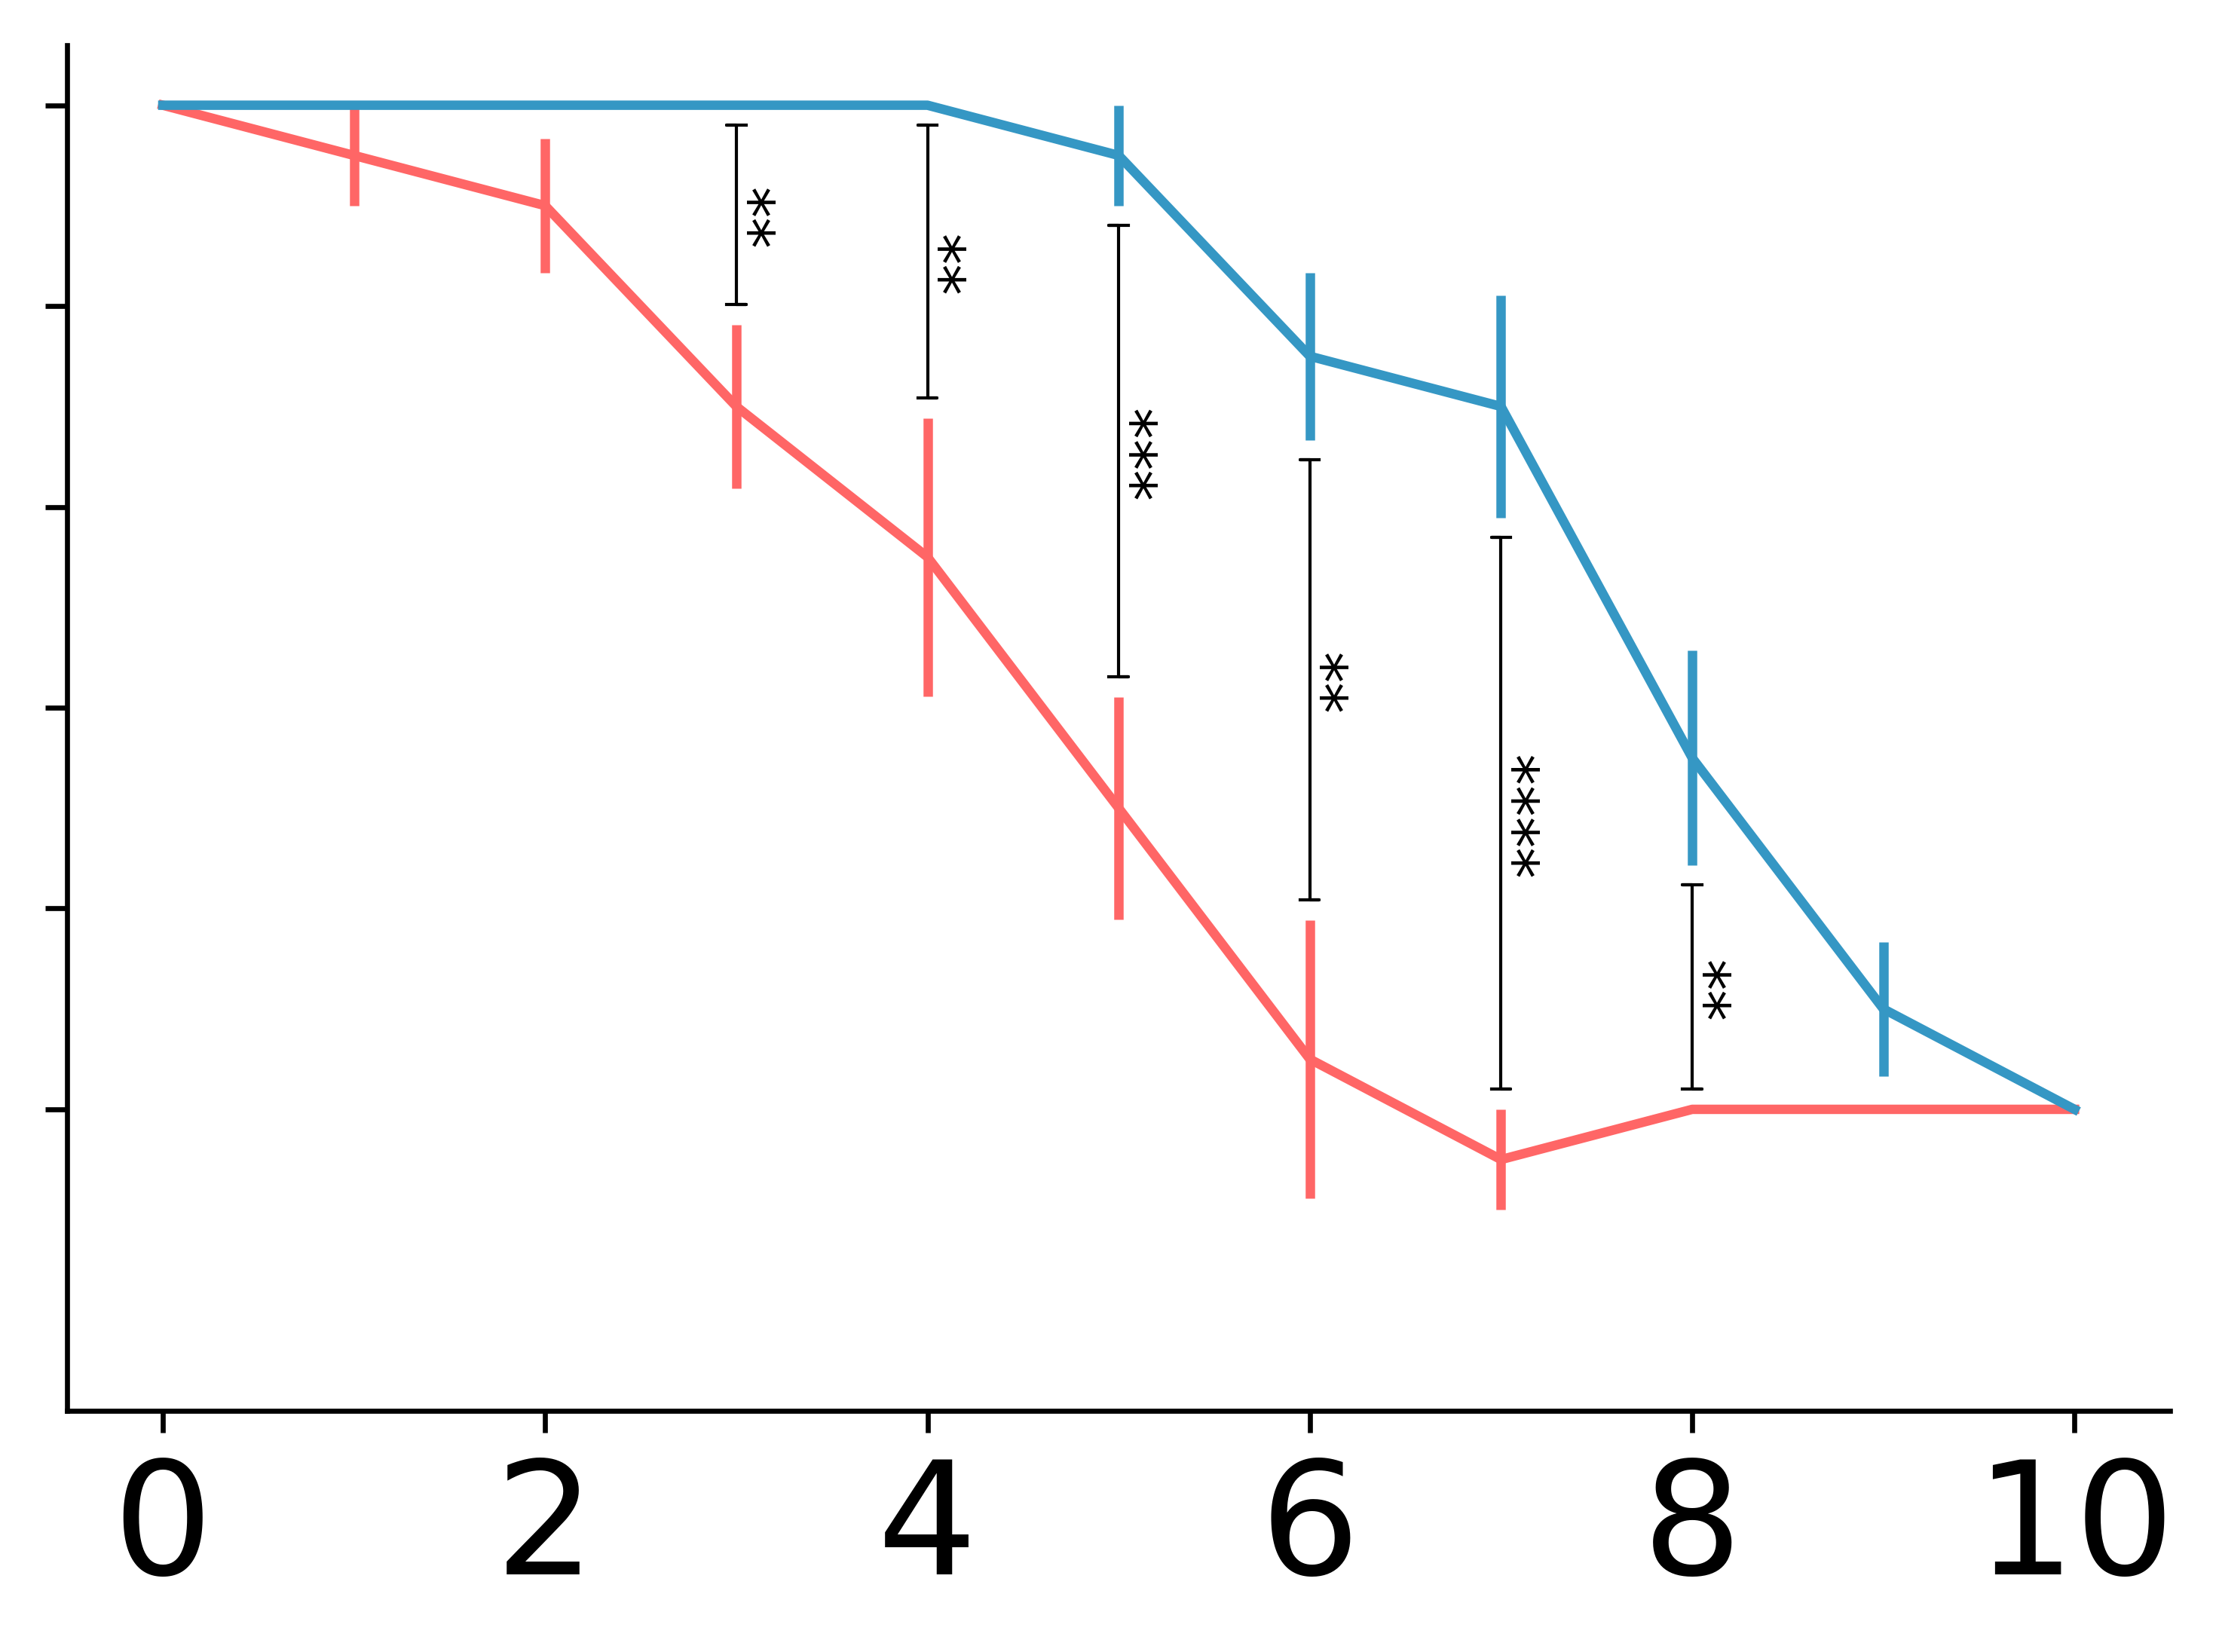

In [51]:
## WITH FDR CORRECTION
XOR_fold = 'PID/logic/XOR/hidden_10/'
dropout = [0.0, 0.5]
num_sources = 10
XOR_dict_list = get_logic_batch_dicts(XOR_fold)
max_dict = get_mask_dict(XOR_dict_list, num_sources, '_max_mask_nimmi', dropout)
min_dict = get_mask_dict(XOR_dict_list, num_sources, '_min_mask_nimmi', dropout)

max_acc, max_sem, min_acc, min_sem = get_mask_avgs(max_dict, min_dict, num_sources, dropout[1])
plt.figure(dpi=600)
plt.ylim(0.35, 1.03)
plt.yticks(np.arange(0.5,1.05,0.1))
plt.xticks(np.arange(0,12,2))
x = range(0, len(max_acc))
y = max_acc
yerr = max_sem
plt.errorbar(x, max_acc, max_sem, label = 'By maximum synergy')
y = min_acc
yerr = min_sem
plt.errorbar(x, min_acc, min_sem, label = 'By minimum synergy')

for i in ind:
    x1 = i + 2
    x2 = x1 - 0.05
    x3 = x1 + 0.05
    y = 0.5*((max_acc[x1] + max_sem[x1]) + (min_acc[x1] - min_sem[x1]))
    col = 'k'
    h = (0.5*((min_acc[x1] - min_sem[x1])-(max_acc[x1] + max_sem[x1])))-0.01
    plt.plot([x2, x3, x1, x1, x2, x3], [y-h, y-h, y-h, y+h, y+h, y+h], lw=.5, c=col)
    plt.text((x1 + 0.2), (y), fdr_str[i], ha='center', va='center', color=col, rotation=90)

plt.minorticks_off()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.gca().yaxis.set_ticklabels([])
# plt.savefig('PaperFigures-Draft5/R3-Fig5.pdf', bbox_inches='tight', transparent=True)
plt.show()

# Animal AI Figures

In [99]:
def get_ckpt_seed_dict_list(exp_fold, num_seeds):
    # exp_fold = 'PID/experiment_type/cur_#/'
    # requires ckpt names to be alphabetical within a configuration
    # for doing pairwise differences
    dict_list = []
    seeds = list(range(0,num_seeds))
    config_fold = os.listdir(exp_fold)
    config_fold = sorted(sorted(config_fold), key = len)
    if '.DS_Store' in config_fold:
        config_fold.remove('.DS_Store')
    
    for seed in range(len(seeds)):
        seed_dict_list = []
        for config in config_fold:
            ckpt_fold = os.listdir(exp_fold + config)
            if '.DS_Store' in ckpt_fold:
                ckpt_fold.remove('.DS_Store')
            ckpt_fold = sorted(sorted(ckpt_fold), key = len)
            for ckpt in ckpt_fold:
                data_files = os.listdir(exp_fold + config + '/' + ckpt)
                for file in data_files:
                    if 'model_{}'.format(seed) in file:
                        seed_dict_list.append(PID_utils.load_dict('{}{}/{}/{}'.format(exp_fold, config, ckpt, file)))
                        break
        dict_list.append(seed_dict_list)
                      
    return dict_list

In [100]:
def get_pvals(dict_list, key):
    t_1 = []
    t_2 = []
    for i in range(0,10):
        t_1.append(dict_list[i][1][key])
        t_2.append(dict_list[i][4][key])
    t_1 = np.array(t_1)
    t_2 = np.array(t_2)
    lay1_p = stats.ttest_rel(t_1[:,0], t_2[:,0])[1]
    lay2_p = stats.ttest_rel(t_1[:,1], t_2[:,1])[1]
    lay3_p = stats.ttest_rel(t_1[:,2], t_2[:,2])[1]
    print(lay1_p)
    print(lay2_p)
    print(lay3_p)
    return [pval_str(lay1_p), pval_str(lay2_p), pval_str(lay3_p)]

0.5113931197892325
0.0036814448564601475
0.0017023546584967006


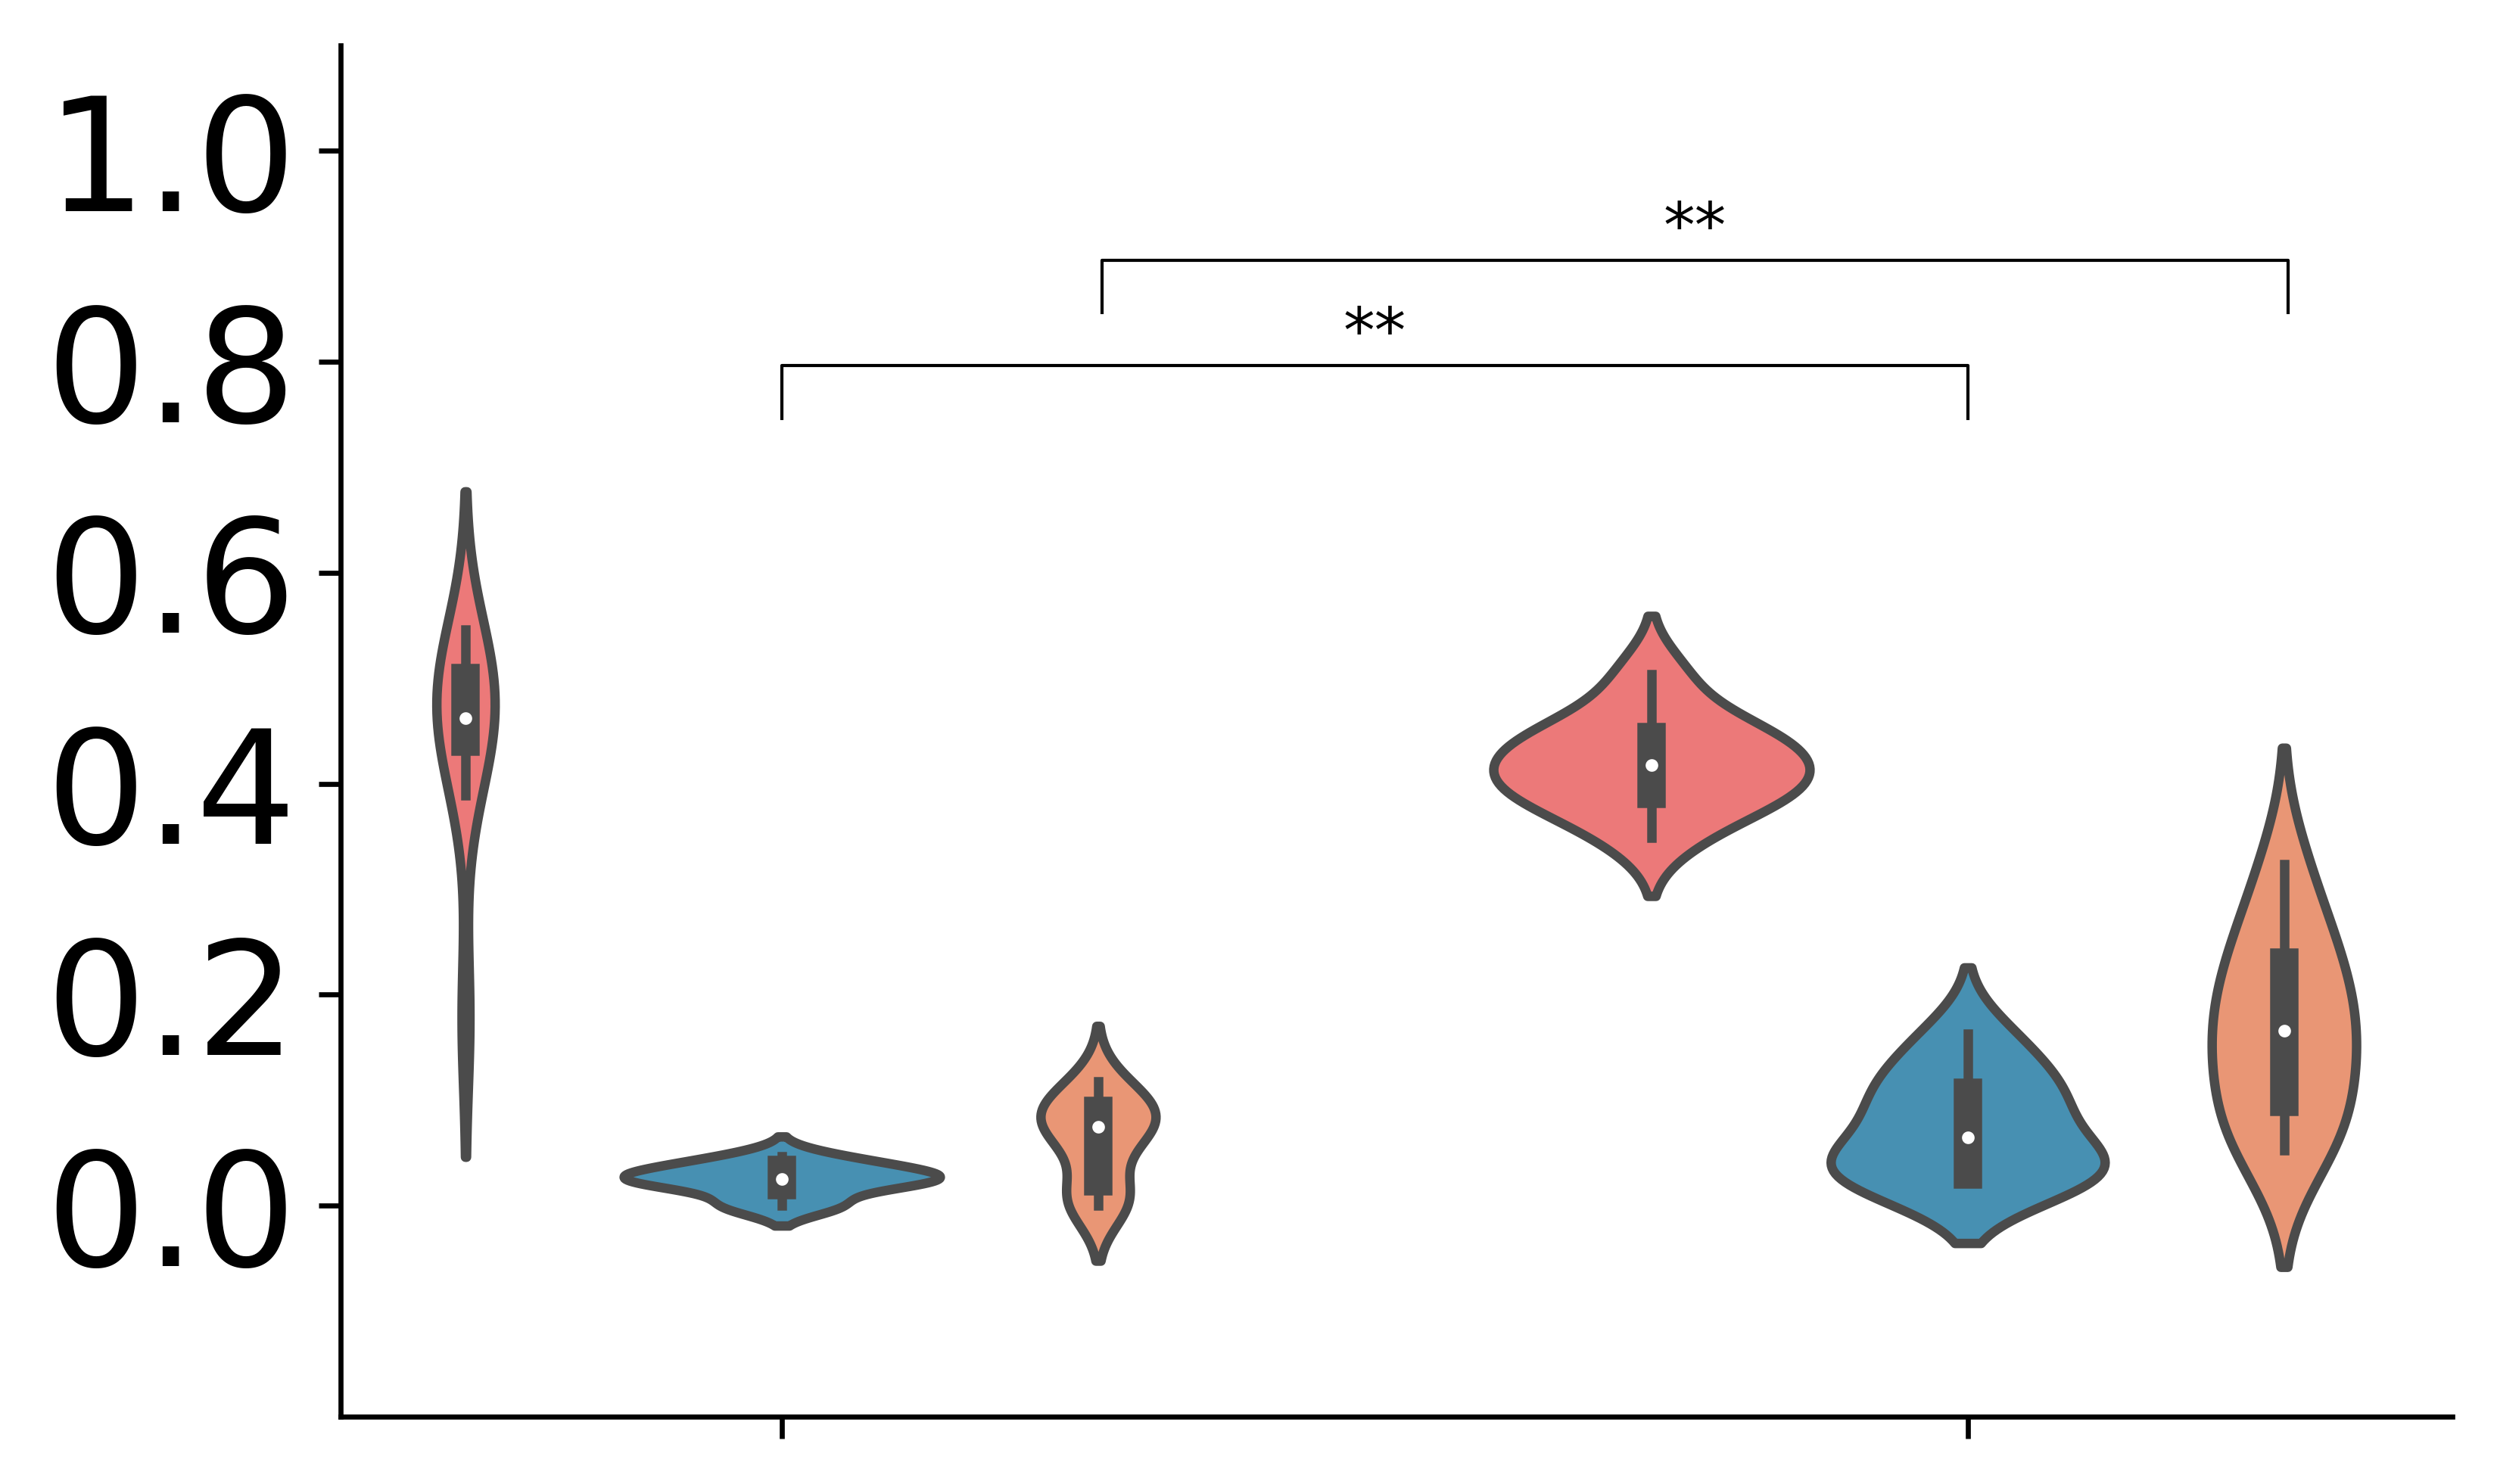

In [107]:
exp_fold = 'PID/animalai/cur_5/'
key = 'k2_x2h_ray_nimmi_syn_avg'
num_seeds = 10
dict_list = get_ckpt_seed_dict_list(exp_fold, num_seeds)
aai_pvals = get_pvals(dict_list, key)

x = []
y1 = []
y2 = []
y3 = []
for i in range(10):
    if dict_list[i][1] != 0:
        x.append(1)
        y1.append(dict_list[i][1][key][0])
        y2.append(dict_list[i][1][key][1])
        y3.append(dict_list[i][1][key][2])    
    if dict_list[i][4] != 0:
        x.append(4)
        y1.append(dict_list[i][4][key][0])
        y2.append(dict_list[i][4][key][1])
        y3.append(dict_list[i][4][key][2])
    
df=pd.DataFrame({'x': x*3, 
                'Synergy': y1+y2+y3,
                'Source': ['Input']*len(y1) + ['Layer 1']*len(y2) + ['Layer 2']*len(y3)})
    
plt.figure(dpi=600)
sns.violinplot(data=df, x = 'x', y = 'Synergy', hue='Source')
plt.xticks(np.arange(0, 2, 1.0), np.array(['', '']))
plt.xlabel('')
plt.ylabel('')
plt.legend(prop={'size': 6})

height = 0.2
if aai_pvals[0] != '':
    x1, x2 = 0, 1
    y, h, col = df['Synergy'].max() + height, 0.05, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
    plt.text((x1+x2)*.5, y+h, aai_pvals[0], ha='center', va='bottom', color=col)
    height += 0.1

if aai_pvals[1] != '':
    x1, x2 = 0, 1
    y, h, col = df['Synergy'].max() + height, 0.05, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
    plt.text((x1+x2)*.5, y+h, aai_pvals[1], ha='center', va='bottom', color=col)
    height += 0.1

if aai_pvals[2] != '':
    x1, x2 = 0+0.27, 1+0.27
    y, h, col = df['Synergy'].max() + height, 0.05, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
    plt.text((x1+x2)*.5, y+h, aai_pvals[2], ha='center', va='bottom', color=col)
    height += 0.1

plt.minorticks_off()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.ylim(-0.2, 1.1)
plt.yticks(np.arange(0.0, 1.2, 0.2))
plt.legend().set_visible(False)
# plt.savefig('PaperFigures-Draft5/R4-Fig1.png', bbox_inches='tight', transparent=True)
plt.show()

0.9706502136544854
0.5586025472286096
0.09781380917185795


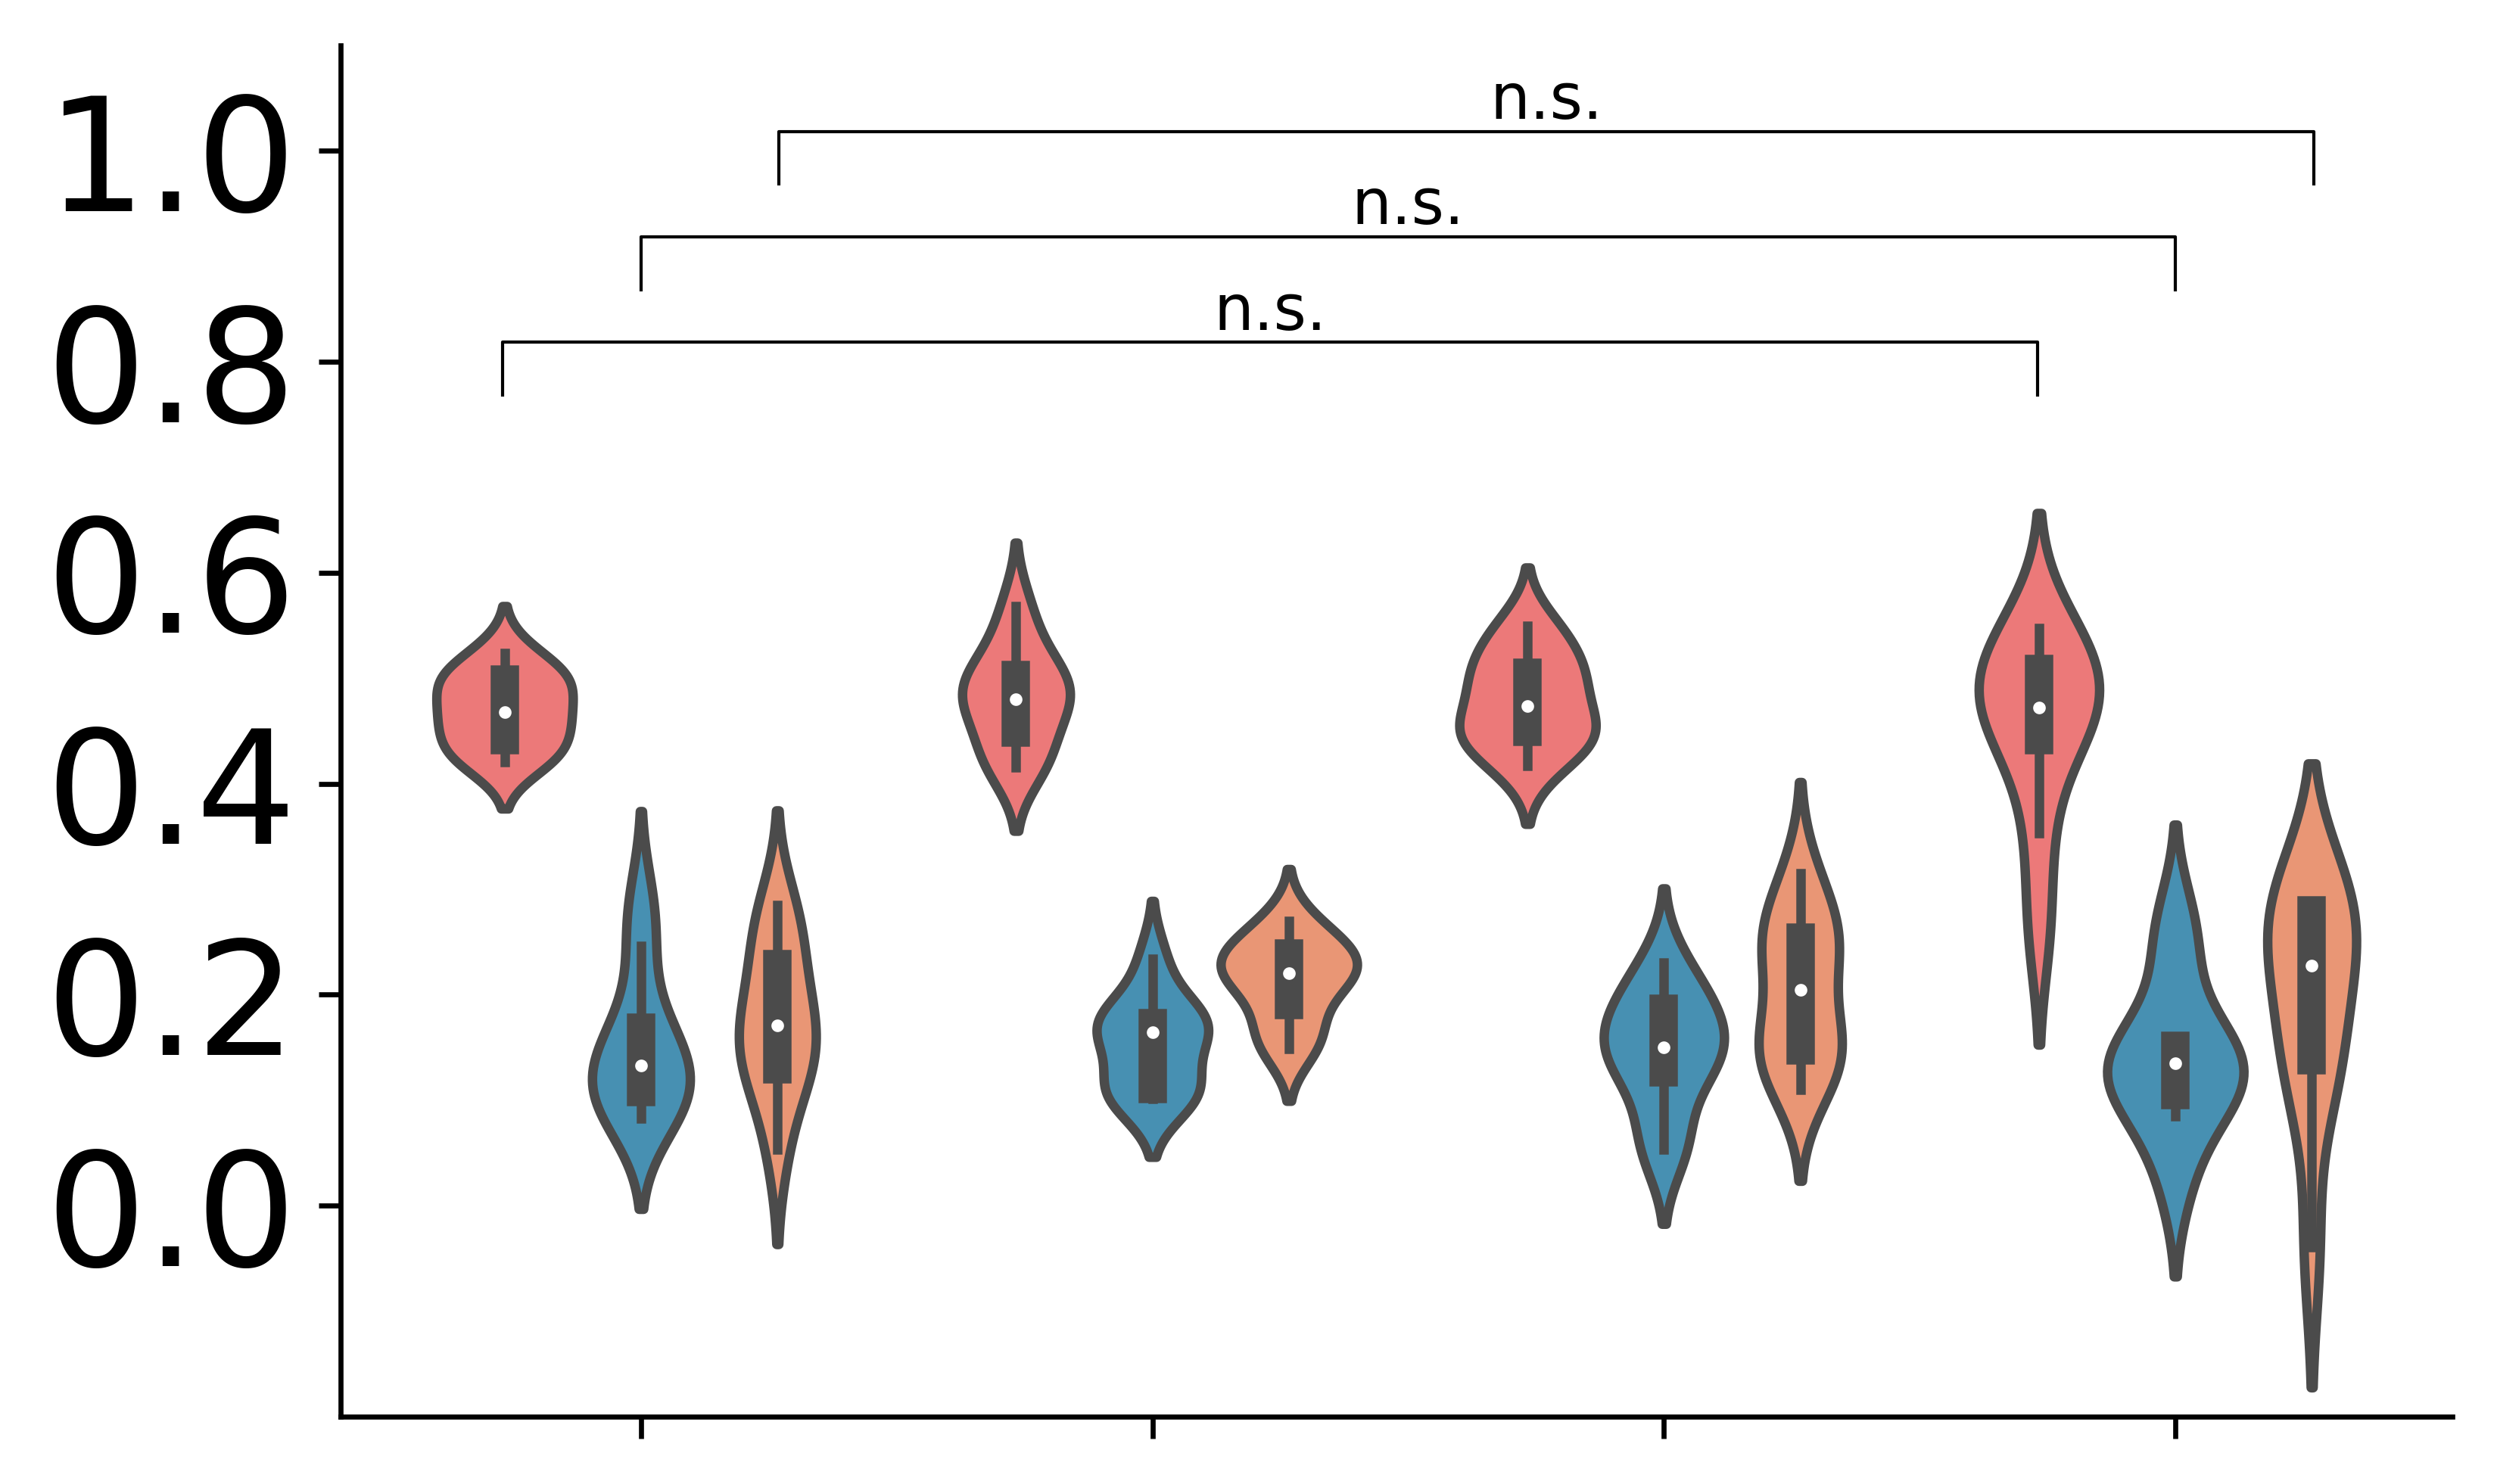

In [108]:
exp_fold = 'PID/animalai/cur_6/'
key = 'k2_x2h_ray_nimmi_syn_avg'
num_seeds = 10
ckpt_idx = [1,3,5,7]
ckpts = ['First Task', 'Second Task', 'Third Task', 'Fourth Task']
dict_list = get_ckpt_seed_dict_list(exp_fold, num_seeds)
aai_pvals = get_pvals(dict_list, key)

x = []
y1 = []
y2 = []
y3 = []
for i in range(10):
        for j in range(len(dict_list[i])):
            if j in ckpt_idx:
                if dict_list[i][j] != 0:
                    x.append(j)
                    y1.append(dict_list[i][j][key][0])
                    y2.append(dict_list[i][j][key][1])
                    y3.append(dict_list[i][j][key][2])
    
df=pd.DataFrame({'x': x*3, 
                'Synergy': y1+y2+y3,
                'Source': ['Input']*len(y1) + ['Layer 1']*len(y2) + ['Layer 2']*len(y3)})
    
plt.figure(dpi=600)
sns.violinplot(data=df, x = 'x', y = 'Synergy', hue='Source')
plt.xticks(np.arange(0, len(ckpts), 1.0), np.array(['','','','']))
plt.xlabel('')
x1, x2 = 0-0.27, 3-0.27
y, h, col = df['Synergy'].max() + 0.2, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
plt.text((x1+x2)*.5, y+h, "n.s.", ha='center', va='bottom', color=col)
x1, x2 = 0, 3
y, h, col = df['Synergy'].max() + 0.3, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
plt.text((x1+x2)*.5, y+h, "n.s.", ha='center', va='bottom', color=col)
x1, x2 = 0+0.27, 3+0.27
y, h, col = df['Synergy'].max() + 0.4, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
plt.text((x1+x2)*.5, y+h, "n.s.", ha='center', va='bottom', color=col)

plt.minorticks_off()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.ylim(-0.2, 1.1)
plt.yticks(np.arange(0.0, 1.2, 0.2))
plt.ylabel('')
plt.legend().set_visible(False)
# plt.savefig('PaperFigures-Draft5/R4-Fig2.png', bbox_inches='tight',transparent=True)
plt.show()

In [8]:
copy_fold = 'PID/animalai/cur_2/'
twobit_fold = 'PID/animalai/cur_1/'
threebit_fold = 'PID/animalai/cur_3/'
distance_fold = 'PID/animalai/cur_4/'

task_folders = [copy_fold,twobit_fold,threebit_fold,distance_fold]
dict_list = []
seeds = list(range(0,10))
    
for seed in range(len(seeds)):
    seed_dict_list = []
    for j in task_folders:
        conf_fold = os.listdir(j)
        conf_fold = sorted(sorted(conf_fold), key = len)
        if '.DS_Store' in conf_fold:
            conf_fold.remove('.DS_Store')
        
        ckpt_fold = os.listdir(j + conf_fold[-1])
        if '.DS_Store' in ckpt_fold:
            ckpt_fold.remove('.DS_Store')
        ckpt_fold = sorted(sorted(ckpt_fold), key = len)
        data_files = os.listdir(j + conf_fold[-1] + '/' + ckpt_fold[-1])
        seed_exists = False
        for file in data_files:
            if 'model_{}'.format(seed) in file:
                seed_dict_list.append(PID_utils.load_dict('{}{}/{}/{}'.format(j, conf_fold[-1], ckpt_fold[-1], file)))
                seed_exists = True
        if not seed_exists:
            seed_dict_list.append(0)
    dict_list.append(seed_dict_list)

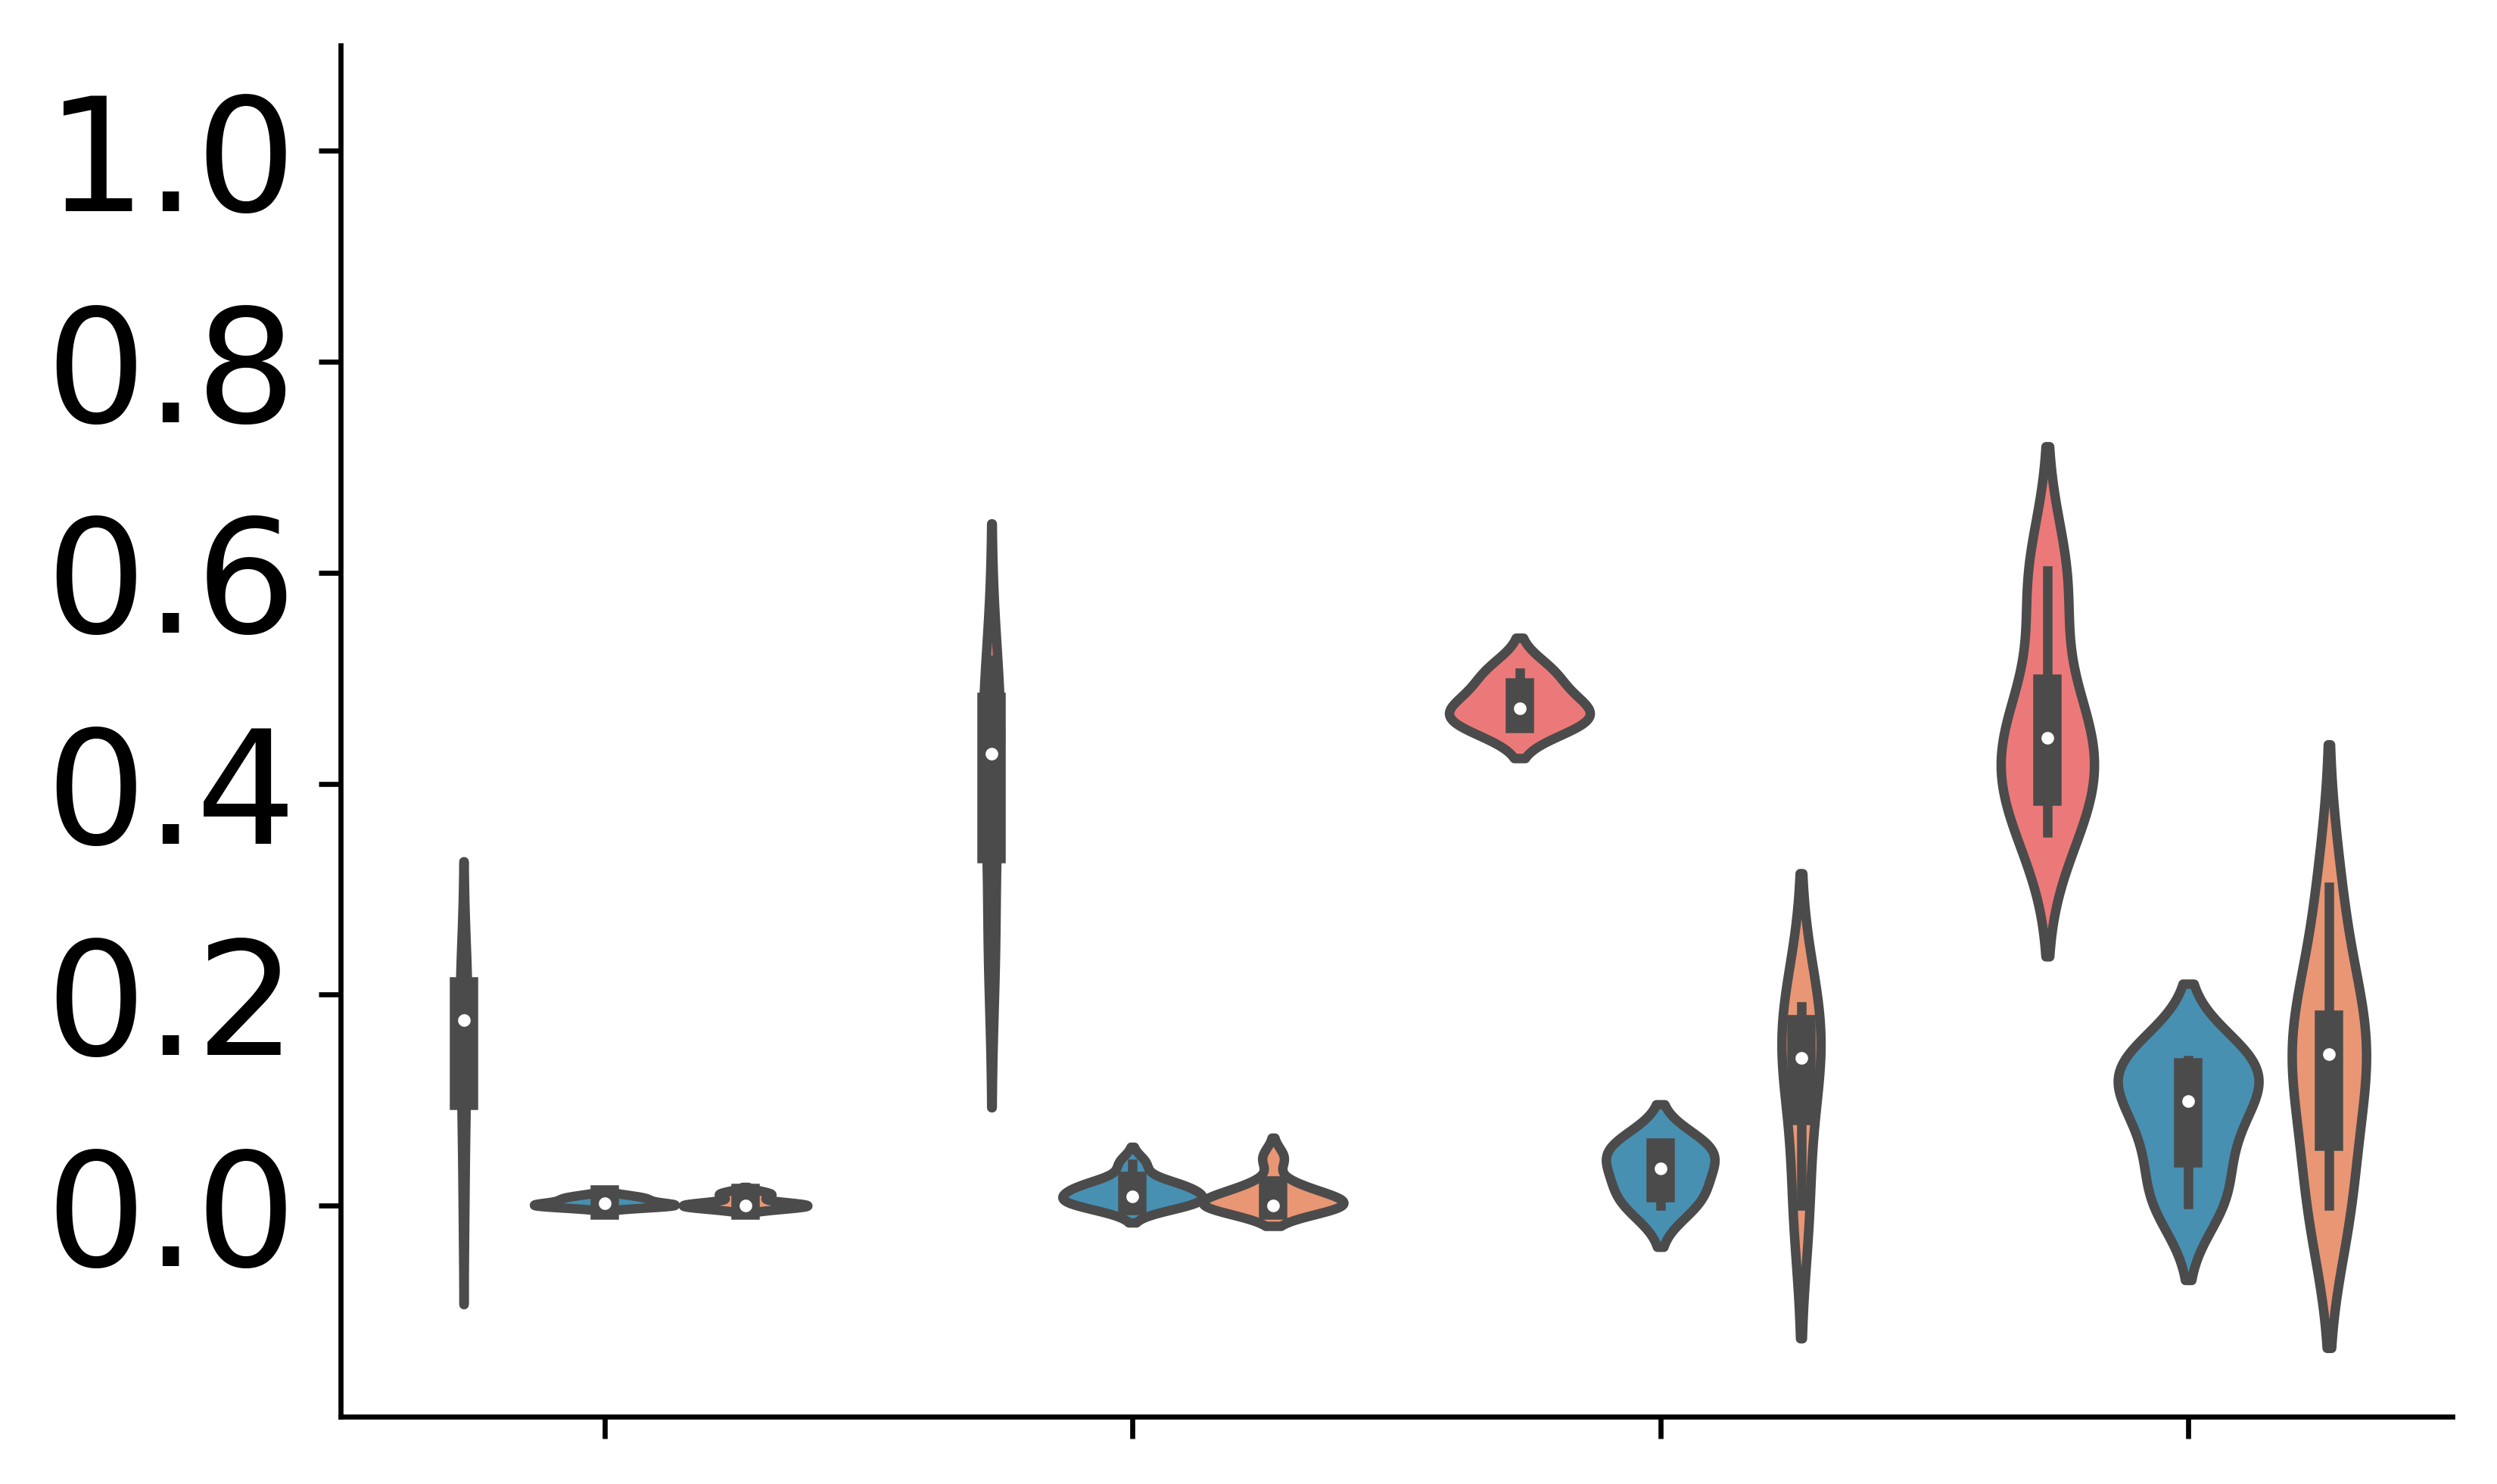

In [9]:
num_seeds = 10
ckpt_idx = [0,1,2,3]
ckpts = ['COPY', '2BitXOR', '3BitXOR', 'DistanceXOR']

title = 'Individual Task Comparison'
key = 'k2_x2h_ray_nimmi_syn_avg'
x = []
y1 = []
y2 = []
y3 = []
for i in range(num_seeds):
    for j in range(len(dict_list[i])):
        if j in ckpt_idx:
            if dict_list[i][j] != 0:
                x.append(j)
                y1.append(dict_list[i][j][key][0])
                y2.append(dict_list[i][j][key][1])
                y3.append(dict_list[i][j][key][2])
    
df=pd.DataFrame({'x': x*3, 
                'Input': y1+y2+y3,
                'Source': ['Input']*len(y1) + ['Layer 1']*len(y2) + ['Layer 2']*len(y3)})
    
plt.figure(dpi=600)
sns.violinplot(data=df, x = 'x', y = 'Input', hue='Source')
lab = np.array(ckpts)
plt.xticks(np.arange(0, len(ckpts), 1.0), np.array(['','','','']))
plt.yticks(np.arange(-0.2, 1.2, 0.2))
plt.ylabel('')
plt.xlabel('')
plt.legend(prop={'size': 8})
plt.minorticks_off()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.ylim(-0.2, 1.1)
plt.yticks(np.arange(0.0, 1.2, 0.2))
plt.legend().set_visible(False)
# plt.savefig('PaperFigures-Draft5/R4-Fig3.pdf', bbox_inches='tight', transparent=True)
plt.show()

# Neurogym Figures

In [10]:
def plot_synergy_performance(folders, num_seeds, key, labels):
    a2b_dict_list = get_ckpt_seed_dict_list(folders[0], num_seeds)
    b2a_dict_list = get_ckpt_seed_dict_list(folders[1], num_seeds)
    anb_dict_list = get_ckpt_seed_dict_list(folders[2], num_seeds)

    init = np.zeros((10,3))
    a2b = np.zeros((10,3))
    b2a = np.zeros((10,3))
    anb = np.zeros((10,3))
    for i in range(0,10):
        init[i][0] = a2b_dict_list[i][0][key][0]
        init[i][1] = a2b_dict_list[i][0]['accuracy']   
        a2b[i][0] = a2b_dict_list[i][2][key][0]
        a2b[i][1] = a2b_dict_list[i][2]['accuracy']
        b2a[i][0] = b2a_dict_list[i][2][key][0]
        b2a[i][1] = b2a_dict_list[i][2]['accuracy']
        anb[i][0] = anb_dict_list[i][2][key][0]
        anb[i][1] = anb_dict_list[i][2]['accuracy']

    plt.figure()
    plt.scatter(a2b[:,0],a2b[:,1], label=labels[0])
    plt.scatter(b2a[:,0],b2a[:,1], label=labels[1])
    plt.scatter(anb[:,0],anb[:,1], label=labels[2])
    plt.minorticks_off()
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')
    plt.ylim(0.35, 1.0)
    plt.xlim(0.17, 0.4)
    plt.xticks(np.arange(0.2, 0.45, 0.05))
    plt.yticks(np.arange(0.4, 1.2, 0.2))
    # plt.savefig('PaperFigures-Draft5/R5-Fig1.pdf', bbox_inches='tight', transparent=True)
    plt.show()

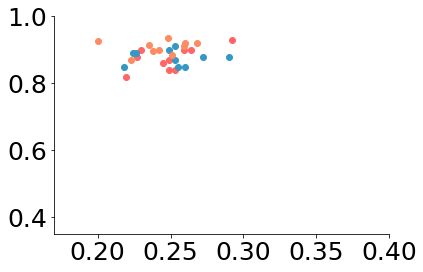

In [11]:
# Congruent tasks (DM1 & CtxDM1)

labels = ['DM1toCtxDM1', 'CtxDM1toDM1', 'DM1&CtxDM1']
folders = ['PID/neurogym/cur_2/', 'PID/neurogym/cur_2R/', 'PID/neurogym/cur_2I/']

plot_synergy_performance(folders, 10, 'k2_xh2h_nimmi_syn_avg', labels)

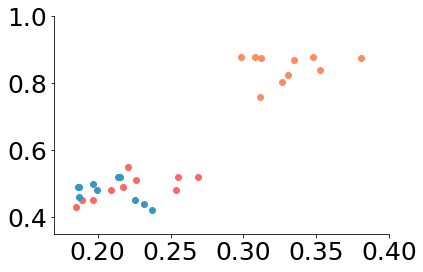

In [12]:
# Incongruent tasks (DM1 & DM2)

labels = ['DM1toDM2', 'DM2toDM1', 'DM1&DM2']
folders = ['PID/neurogym/cur_1/', 'PID/neurogym/cur_1R/', 'PID/neurogym/cur_1I/']

plot_synergy_performance(folders, 10, 'k2_xh2h_nimmi_syn_avg', labels)


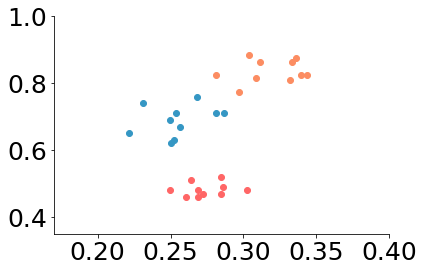

In [13]:
# Other incongruent tasks (DM1 & CtxDM2)

labels = ['DM1toCtxDM2', 'CtxDM2toDM1', 'DM1&CtxDM2']
folders = ['PID/neurogym/cur_3/', 'PID/neurogym/cur_3R/', 'PID/neurogym/cur_3I/']

plot_synergy_performance(folders, 10, 'k2_xh2h_nimmi_syn_avg', labels)


In [14]:
def get_batch_dict_list(exp_fold):
    # exp_folder = 'PID/experiment/cur_#/'
    # requires ckpt names to be alphabetical within a configuration
    dict_list = []
    conf_fold = os.listdir(exp_fold)
    if '.DS_Store' in conf_fold:
        conf_fold.remove('.DS_Store')
    conf_fold = sorted(sorted(conf_fold), key = len)
    for i in conf_fold:
        ckpt_fold = os.listdir(exp_fold + i)
        if '.DS_Store' in ckpt_fold:
            ckpt_fold.remove('.DS_Store')
        ckpt_fold = sorted(sorted(ckpt_fold), key = len)
        for j in ckpt_fold:
            dict_list.append(PID_utils.load_dict(exp_fold + i + '/' + j + '/batch.json'))
            
    return dict_list

In [15]:
# Interleaved curriculums
key = 'k2_xh2h_nimmi_syn_avg_avg'

A2B_fold_I = 'PID/neurogym/cur_1I/'
A2B_dict_list = get_batch_dict_list(A2B_fold_I)[-1]
A2C_fold_I = 'PID/neurogym/cur_2I/'
A2C_dict_list = get_batch_dict_list(A2C_fold_I)[-1]
A2D_fold_I = 'PID/neurogym/cur_3I/'
A2D_dict_list = get_batch_dict_list(A2D_fold_I)[-1]
A2X = [0.0, A2B_dict_list[key][0], \
      A2C_dict_list[key][0],
      A2D_dict_list[key][0]]

B2A_fold_I = 'PID/neurogym/cur_1I/' ##
B2A_dict_list = get_batch_dict_list(B2A_fold_I)[-1]
B2C_fold_I = 'PID/neurogym/cur_5I/'## DM2->CtxDM1
B2C_dict_list = get_batch_dict_list(B2C_fold_I)[-1]
B2D_fold_I = 'PID/neurogym/cur_4I/' ## DM2->CtxDM2
B2D_dict_list = get_batch_dict_list(B2D_fold_I)[-1]
B2X = [B2A_dict_list[key][0], 0.0, 
       B2C_dict_list[key][0], 
       B2D_dict_list[key][0]]

C2A_fold_I = 'PID/neurogym/cur_2I/'
C2A_dict_list = get_batch_dict_list(C2A_fold_I)[-1]
C2B_fold_I = 'PID/neurogym/cur_5I/' ## CtxDM1->DM2
C2B_dict_list = get_batch_dict_list(C2B_fold_I)[-1]
C2D_fold_I = 'PID/neurogym/cur_6I/' ## CtxDM1->CtxDM2
C2D_dict_list = get_batch_dict_list(C2D_fold_I)[-1]
C2X = [C2A_dict_list[key][0], 
       C2B_dict_list[key][0], 0.0, 
       C2D_dict_list[key][0]]

D2A_fold_I = 'PID/neurogym/cur_3I/'
D2A_dict_list = get_batch_dict_list(D2A_fold_I)[-1]
D2B_fold_I = 'PID/neurogym/cur_4I/' ## CtxDM2 -> DM2
D2B_dict_list = get_batch_dict_list(D2B_fold_I)[-1]
D2C_fold_I = 'PID/neurogym/cur_6I/' ## CtxDM2 -> CtxDM1
D2C_dict_list = get_batch_dict_list(D2C_fold_I)[-1]
D2X = [D2A_dict_list[key][0], 
       D2B_dict_list[key][0], 
       D2C_dict_list[key][0], 0.0]

I_syn = np.array([A2X, B2X, C2X, D2X])

In [16]:
# Sequential curriculums
key = 'k2_xh2h_nimmi_syn_avg_avg'


A2B_fold_S = 'PID/neurogym/cur_1/'
A2B_dict_list = get_batch_dict_list(A2B_fold_S)[-1]
A2C_fold_S = 'PID/neurogym/cur_2/'
A2C_dict_list = get_batch_dict_list(A2C_fold_S)[-1]
A2D_fold_S = 'PID/neurogym/cur_3/'
A2D_dict_list = get_batch_dict_list(A2D_fold_S)[-1]
A2X = [0.0, A2B_dict_list[key][0], \
      A2C_dict_list[key][0],
      A2D_dict_list[key][0]]


B2A_fold_S = 'PID/neurogym/cur_1R/' ##
B2A_dict_list = get_batch_dict_list(B2A_fold_S)[-1]
B2C_fold_S = 'PID/neurogym/cur_5/' ## DM2->CtxDM1
B2C_dict_list = get_batch_dict_list(B2C_fold_S)[-1]
B2D_fold_S = 'PID/neurogym/cur_4/' ## DM2->CtxDM2
B2D_dict_list = get_batch_dict_list(B2D_fold_S)[-1]
B2X = [B2A_dict_list[key][0], 0.0, 
       B2C_dict_list[key][0], 
       B2D_dict_list[key][0]]

C2A_fold_S = 'PID/neurogym/cur_2R/'
C2A_dict_list = get_batch_dict_list(C2A_fold_S)[-1]
C2B_fold_S = 'PID/neurogym/cur_5R/' ## CtxDM1->DM2
C2B_dict_list = get_batch_dict_list(C2B_fold_S)[-1]
C2D_fold_S = 'PID/neurogym/cur_6/'## CtxDM1->CtxDM2
C2D_dict_list = get_batch_dict_list(C2D_fold_S)[-1]
C2X = [C2A_dict_list[key][0], 
       C2B_dict_list[key][0], 0.0, 
       C2D_dict_list[key][0]]

D2A_fold_S = 'PID/neurogym/cur_3R/'
D2A_dict_list = get_batch_dict_list(D2A_fold_S)[-1]
D2B_fold_S = 'PID/neurogym/cur_4R/' ## CtxDM2 -> DM2
D2B_dict_list = get_batch_dict_list(D2B_fold_S)[-1]
D2C_fold_S = 'PID/neurogym/cur_6R/' ## CtxDM2 -> CtxDM1
D2C_dict_list = get_batch_dict_list(D2C_fold_S)[-1]
D2X = [D2A_dict_list[key][0], 
       D2B_dict_list[key][0], 
       D2C_dict_list[key][0], 0.0]

S_syn = np.array([A2X, B2X, C2X, D2X])

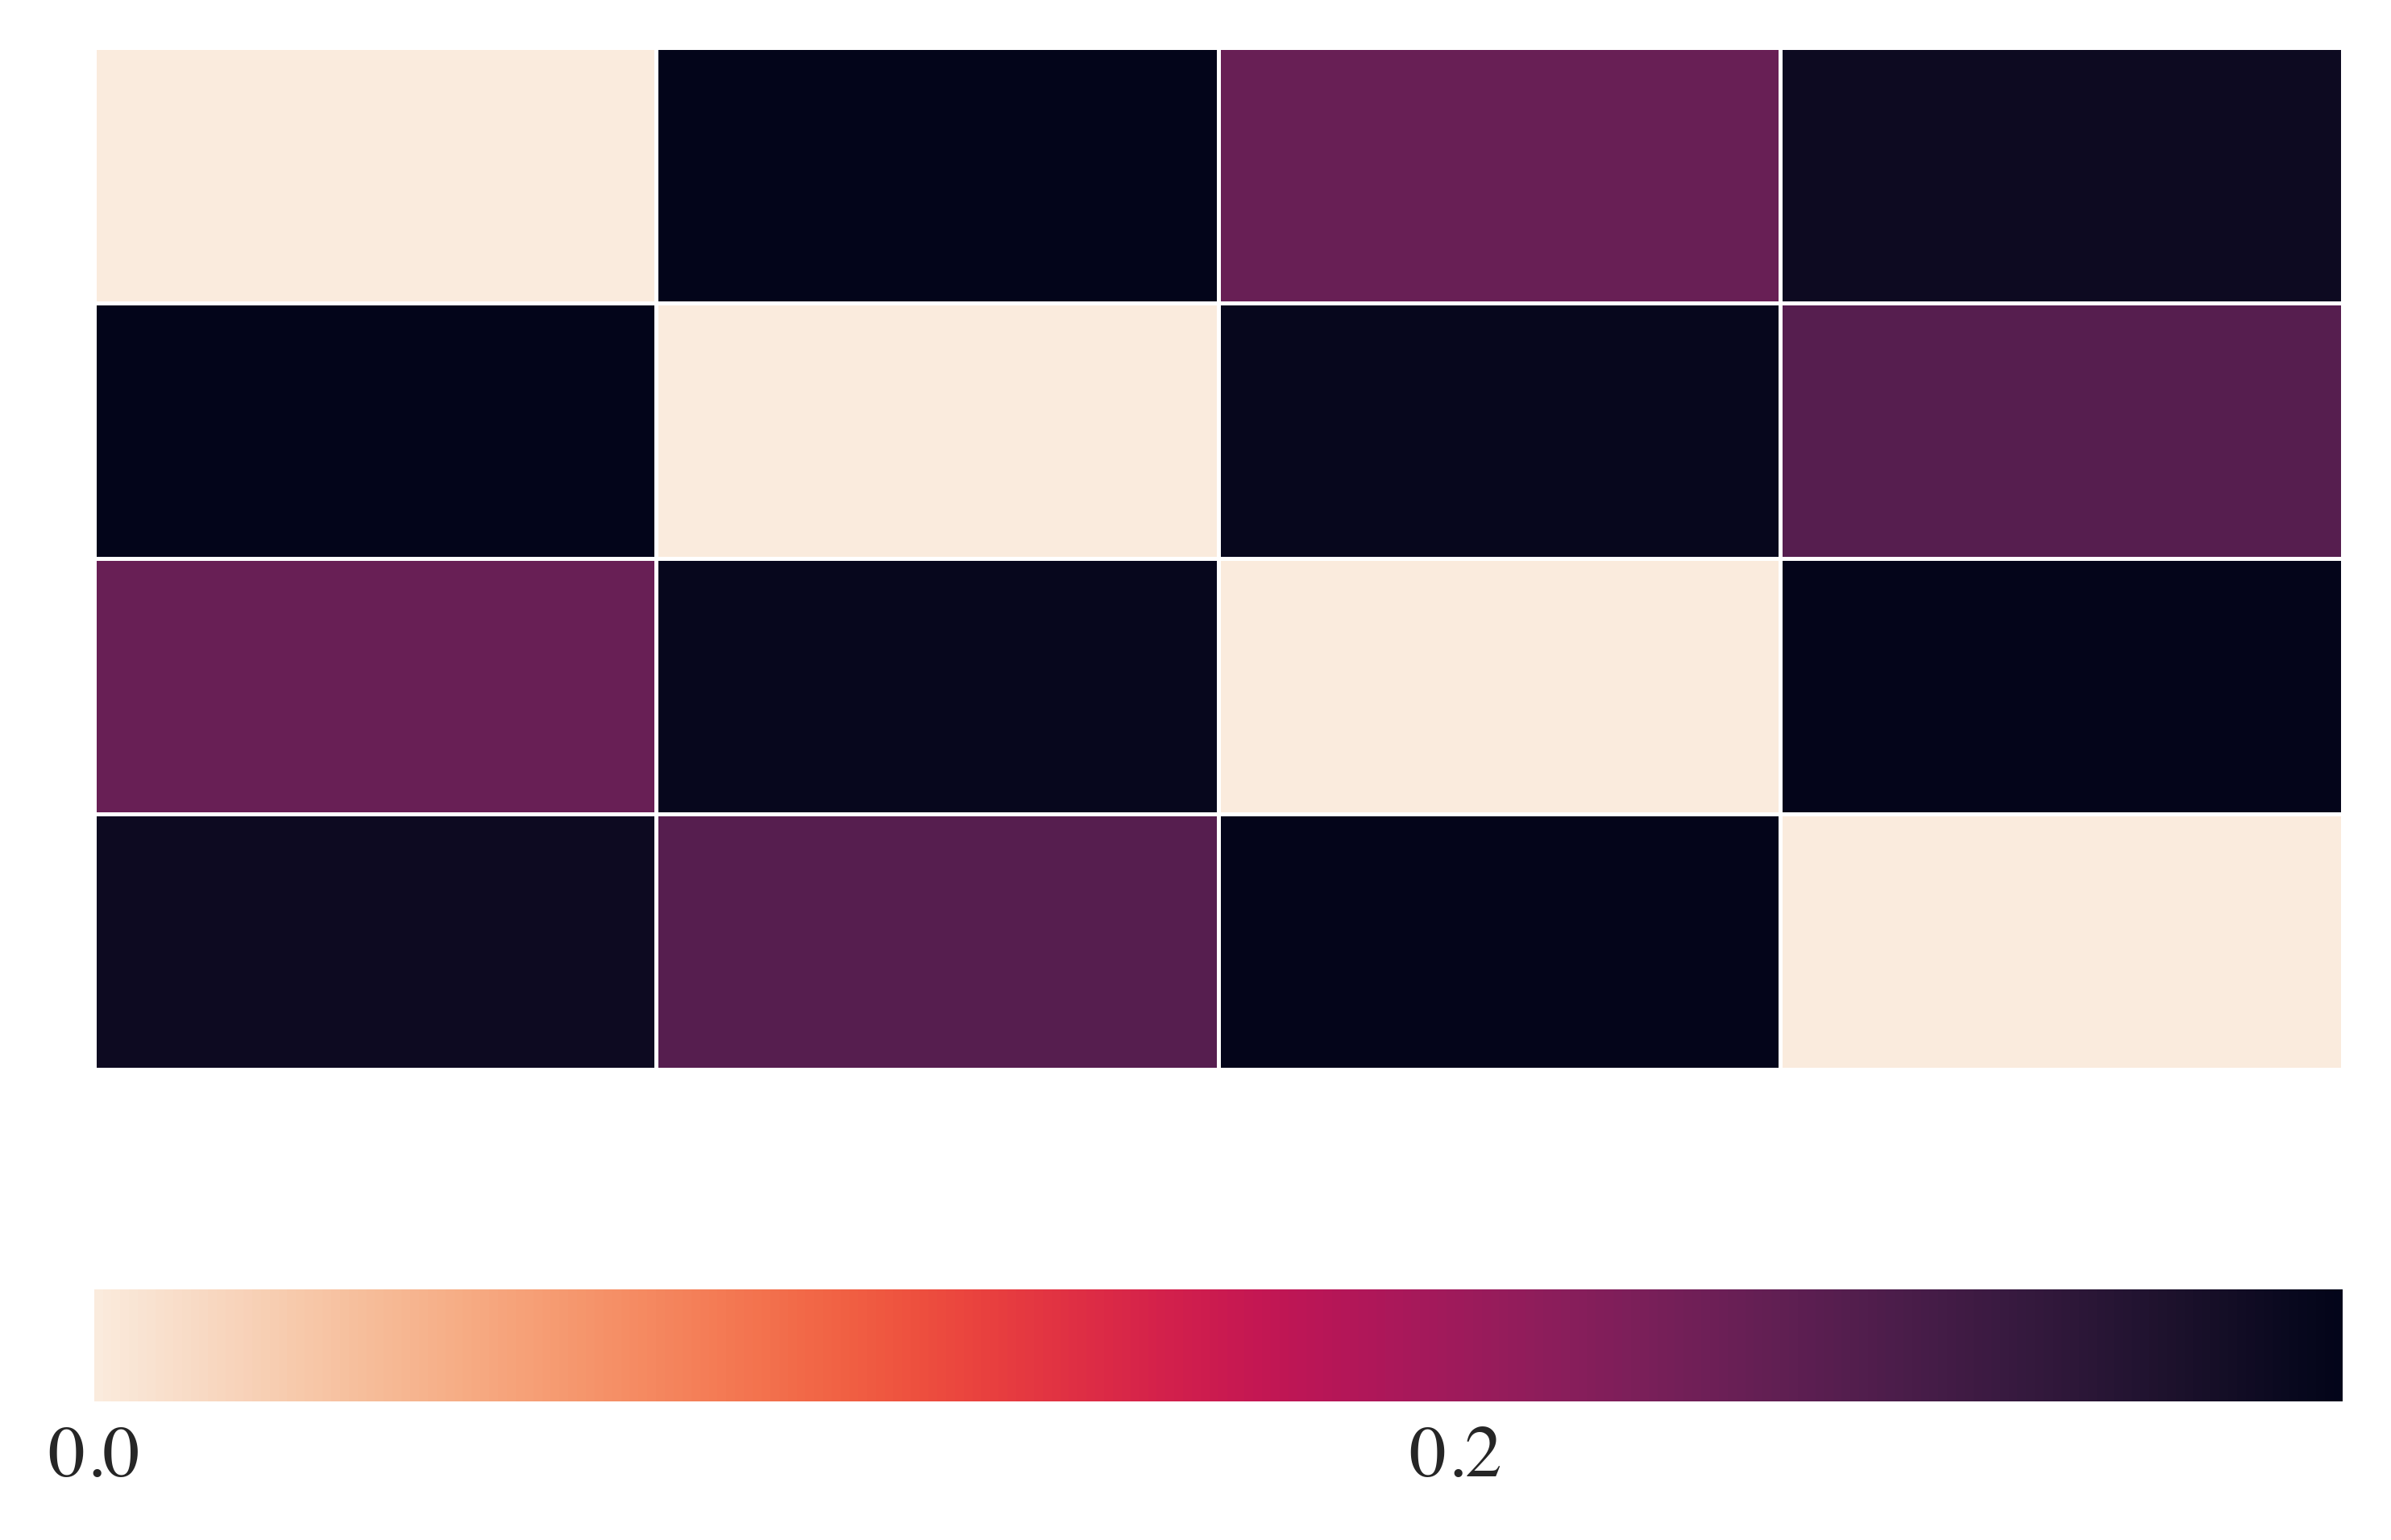

In [17]:
tasks = ["DM1", "DM2", "CtxDM1", "CtxDM2"]

plt.figure(dpi=600) 
sns.set(font="Times")
ax = sns.heatmap(I_syn, cmap="rocket_r",  fmt = '',\
                 linewidths=.5, annot_kws={'fontsize': 'xxx-large'}, cbar=True, cbar_kws = dict(use_gridspec=False,location="bottom", ticks=[0.0,0.2]))
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks(np.arange(len(tasks)))
ax.set_yticks(np.arange(len(tasks) + 1))
ax.minorticks_off()
ax.set_xticks(np.arange(len(tasks))+0.5)
ax.set_yticks(np.arange(len(tasks))+0.5)
ax.set_xticklabels(['','','',''])
ax.set_yticklabels(['','','',''],va='center')
ax.minorticks_off()
ax.collections[0].colorbar.ax.yaxis.set_ticks([], minor=True)
ax.collections[0].colorbar.ax.locator_params(nbins=2)
ax.collections[0].colorbar.ax.tick_params(axis='both', which='both', length=0)
ax.collections[0].colorbar.set_label("Synergy")
ax.collections[0].colorbar.set_label("")
ax.tick_params(axis='both', which='both', length=0)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
# plt.savefig('PaperFigures-Draft5/R5-Fig5.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [18]:
def get_ttest_data_list(exp_fold, conf_idx, ckpt_idx, key):
    # exp_fold = 'PID/cur_#/'
    # requires ckpt names to be alphabetical within a configuration
    data_list = []
    conf_fold = os.listdir(exp_fold)
    conf_fold = sorted(sorted(conf_fold), key = len)
    if '.DS_Store' in conf_fold:
        conf_fold.remove('.DS_Store')
    
    ckpt_fold = os.listdir(exp_fold + conf_fold[conf_idx])
    if '.DS_Store' in ckpt_fold:
        ckpt_fold.remove('.DS_Store')
    ckpt_fold = sorted(sorted(ckpt_fold), key = len)
    data_files = os.listdir(exp_fold + conf_fold[conf_idx] + '/' + ckpt_fold[ckpt_idx])
    if '.DS_Store' in data_files:
        data_files.remove('.DS_Store')
    if 'batch.json' in data_files:
        data_files.remove('batch.json')
    data_files = sorted(sorted(data_files), key = len)
    for i in data_files:
        t_dict = PID_utils.load_dict(exp_fold + conf_fold[conf_idx] + '/' + ckpt_fold[ckpt_idx] + '/' + i)
        data_list.append(t_dict[key])

    return data_list

In [20]:
def heatmap_pval_str(exp_fold_S, exp_fold_I, p_key):
    data1 = get_ttest_data_list(exp_fold_S, 1, 0, p_key)
    data2 = get_ttest_data_list(exp_fold_I, 0, 2, p_key)
    xh2h_pval = stats.ttest_ind(data1, data2)
    return pval_str(xh2h_pval.pvalue)

In [21]:
p_key = 'k2_xh2h_nimmi_syn_avg'

A2X_p = ["",
        heatmap_pval_str(A2B_fold_S, A2B_fold_I, p_key),
        heatmap_pval_str(A2C_fold_S, A2C_fold_I, p_key),
        heatmap_pval_str(A2D_fold_S, A2D_fold_I, p_key)]

B2X_p = [heatmap_pval_str(B2A_fold_S, B2A_fold_I, p_key),
        "",
        heatmap_pval_str(B2C_fold_S, B2C_fold_I, p_key),
        heatmap_pval_str(B2D_fold_S, B2D_fold_I, p_key)]

C2X_p = [heatmap_pval_str(C2A_fold_S, C2A_fold_I, p_key),
        heatmap_pval_str(C2B_fold_S, C2B_fold_I, p_key),
        "",
        heatmap_pval_str(C2D_fold_S, C2D_fold_I, p_key)]

D2X_p = [heatmap_pval_str(D2A_fold_S, D2A_fold_I, p_key),
        heatmap_pval_str(D2B_fold_S, D2B_fold_I, p_key),
        heatmap_pval_str(D2C_fold_S, D2C_fold_I, p_key),
        ""]

labels = np.array([A2X_p, B2X_p, C2X_p, D2X_p])

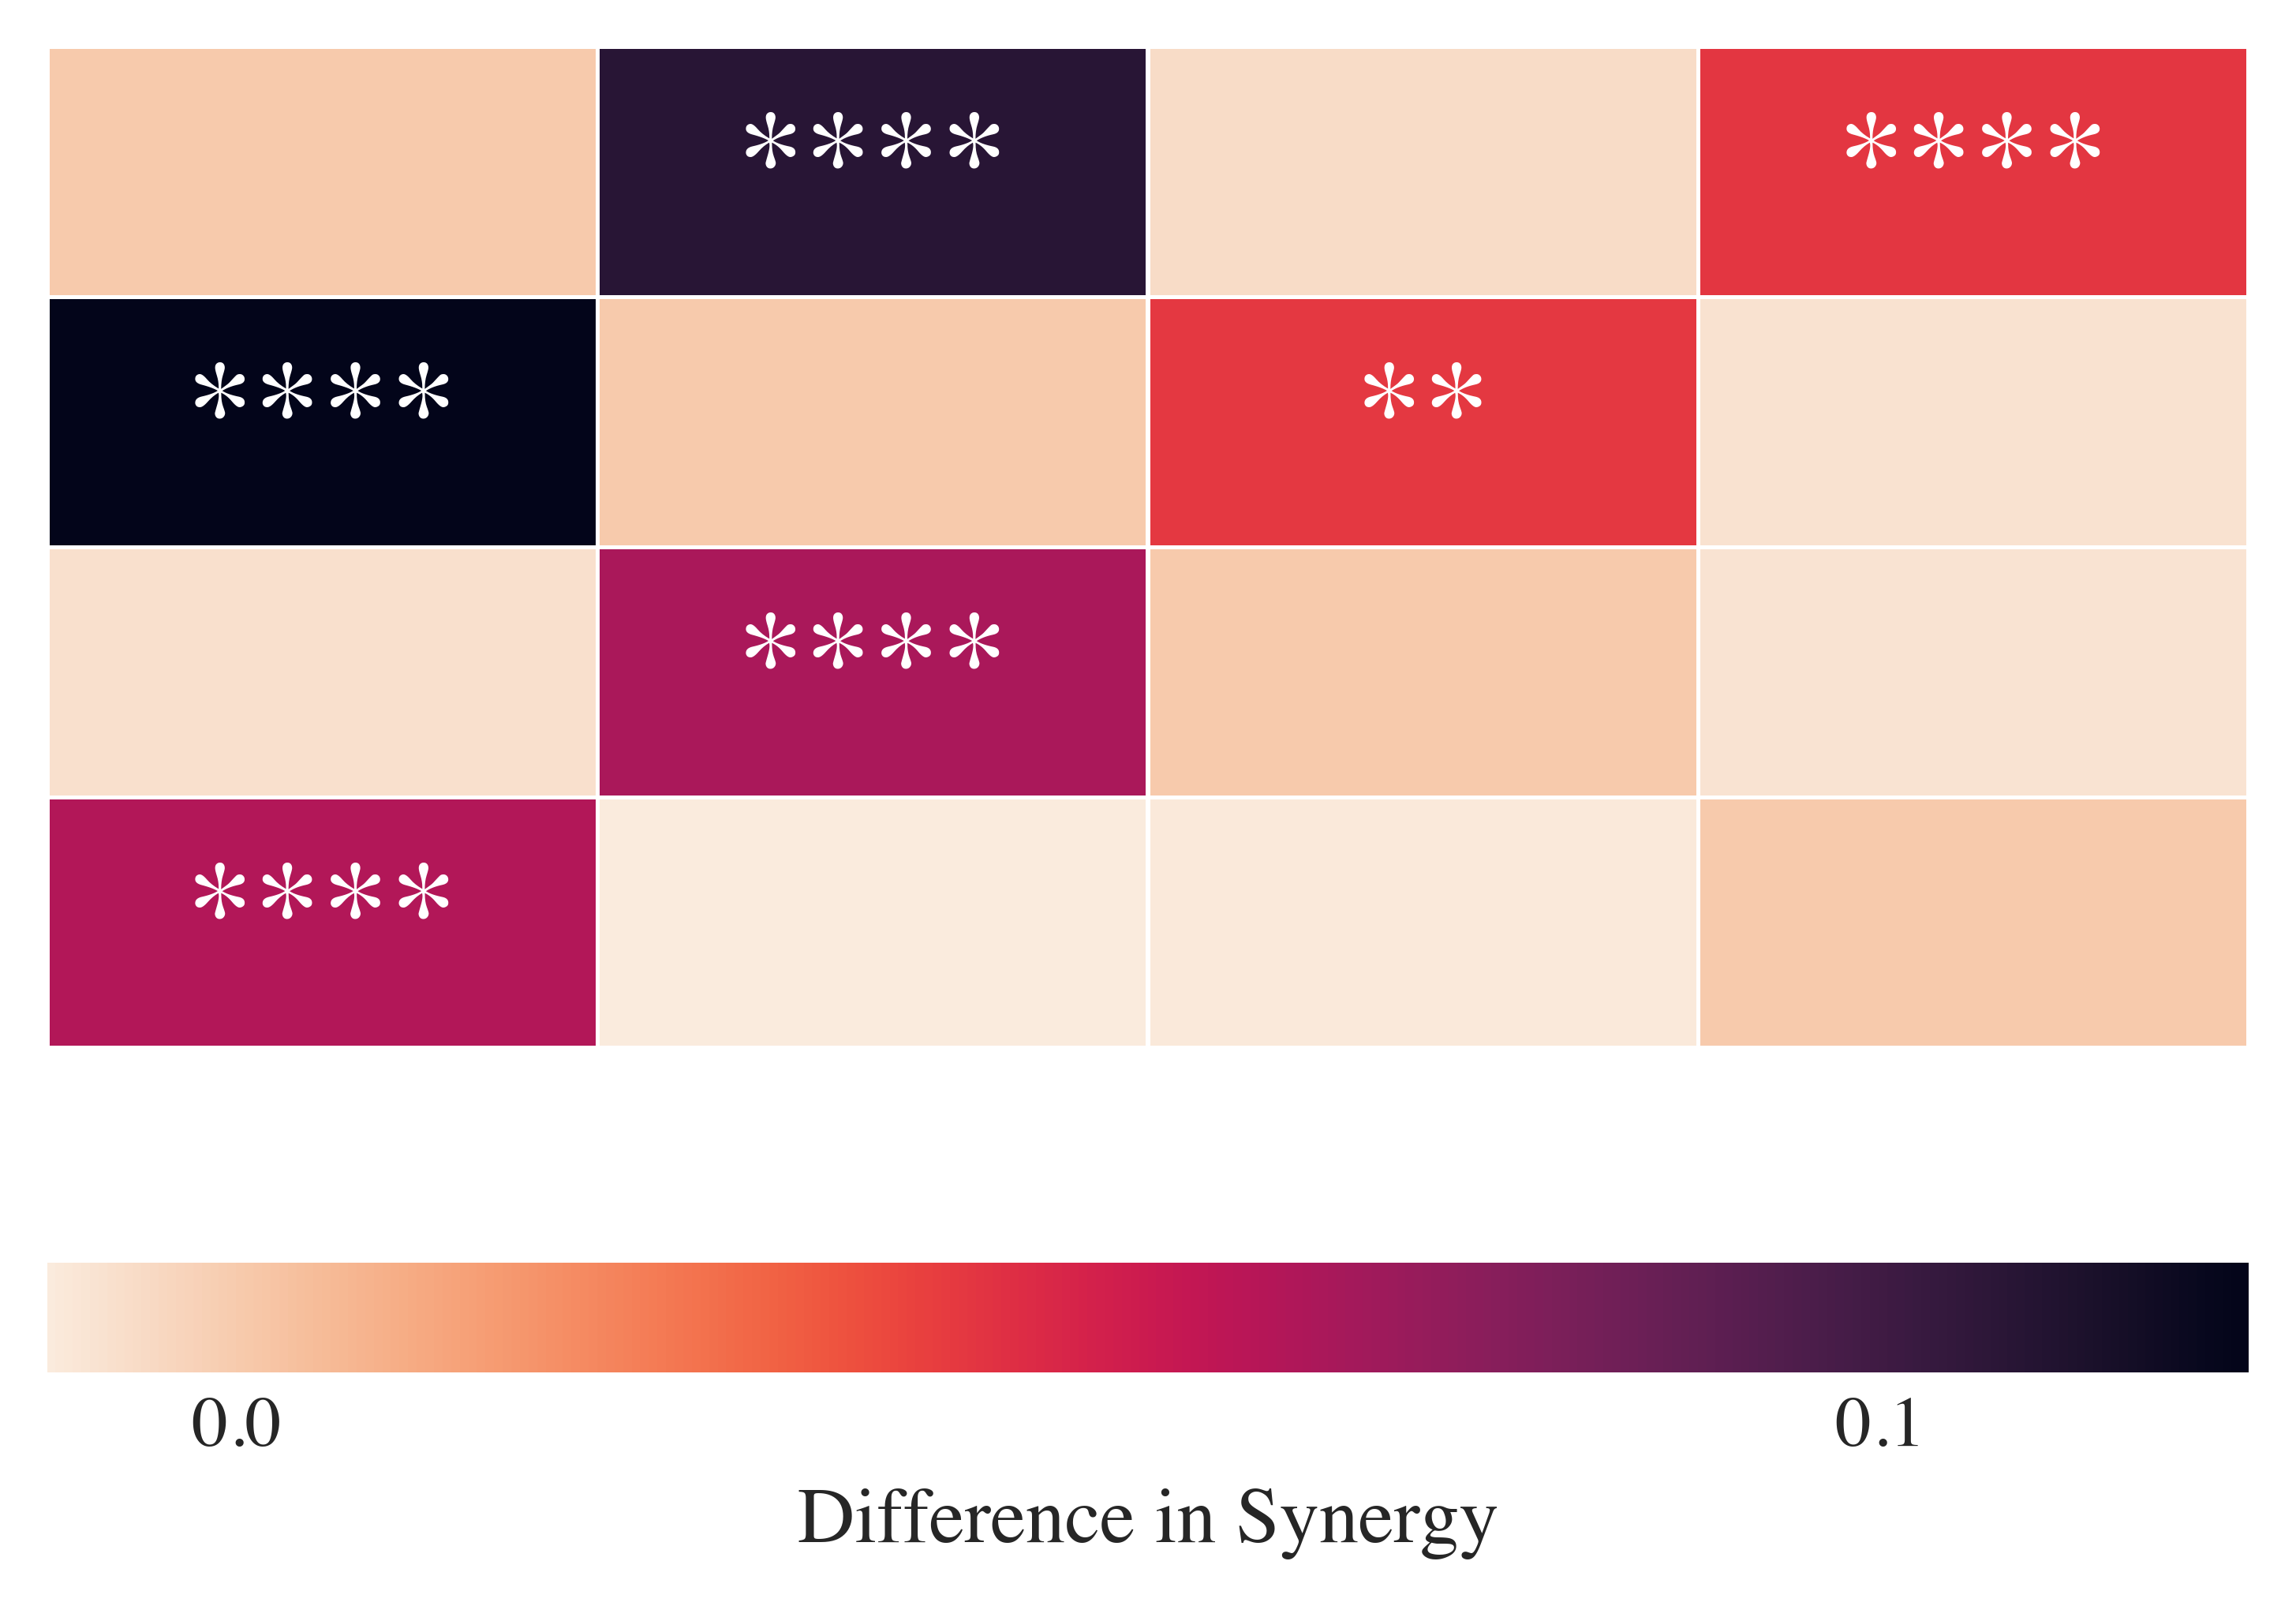

In [22]:
tasks = ["DM1", "DM2", "CtxDM1", "CtxDM2"]

syn_dif = I_syn - S_syn

plt.figure(dpi=600) #plt.figure(figsize=(9,8))
ax = sns.heatmap(syn_dif, cmap="rocket_r", fmt = '', annot = labels,\
                 linewidths=.5, annot_kws={'fontsize': 'xx-large'},cbar=True, cbar_kws = dict(use_gridspec=False,location="bottom", ticks=[0.0,0.1])) # vmin=0, vmax=1,
ax.set_ylabel('') 
ax.set_xlabel('')
ax.set_xticks(np.arange(len(tasks))+0.5)
ax.set_yticks(np.arange(len(tasks))+0.5)
ax.set_xticklabels(['','','',''])
ax.set_yticklabels(['','','',''],va='center')
ax.minorticks_off()
ax.collections[0].colorbar.ax.yaxis.set_ticks([], minor=True)
ax.collections[0].colorbar.ax.locator_params(nbins=2)
ax.collections[0].colorbar.ax.tick_params(axis='both', which='both', length=0)
ax.collections[0].colorbar.set_label("Difference in Synergy")
ax.tick_params(axis='both', which='both', length=0)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
# plt.savefig('PaperFigures-Draft6-COPY/dif_colorbar.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [23]:
key = 'k2_xh2h_nimmi_syn_avg'

DM1DM2 = np.zeros((10))
DM1CtxDM1 = np.zeros(10)
DM1CtxDM2 = np.zeros(10)
DM2CtxDM1 = np.zeros(10)
DM2CtxDM2 = np.zeros(10)
CtxDM1CtxDM2 = np.zeros(10)
num_seeds = 10

exp_fold = 'PID/neurogym/cur_1I/'
DM1DM2_dict = get_ckpt_seed_dict_list(exp_fold, num_seeds)
exp_fold = 'PID/neurogym/cur_2I/'
DM1CtxDM1_dict = get_ckpt_seed_dict_list(exp_fold, num_seeds)
exp_fold = 'PID/neurogym/cur_3I/'
DM1CtxDM2_dict = get_ckpt_seed_dict_list(exp_fold, num_seeds)
exp_fold = 'PID/neurogym/cur_5I/'
DM2CtxDM1_dict = get_ckpt_seed_dict_list(exp_fold, num_seeds)
exp_fold = 'PID/neurogym/cur_4I/'
DM2CtxDM2_dict = get_ckpt_seed_dict_list(exp_fold, num_seeds)
exp_fold = 'PID/neurogym/cur_6I/'
CtxDM1CtxDM2_dict = get_ckpt_seed_dict_list(exp_fold, num_seeds)


for i in range(0,10):
    DM1DM2[i] = DM1DM2_dict[i][-1][key][0]
    DM1CtxDM1[i] = DM1CtxDM1_dict[i][-1][key][0]
    DM1CtxDM2[i] = DM1CtxDM2_dict[i][-1][key][0]
    DM2CtxDM1[i] = DM2CtxDM1_dict[i][-1][key][0]
    DM2CtxDM2[i] = DM2CtxDM2_dict[i][-1][key][0]
    CtxDM1CtxDM2[i] = CtxDM1CtxDM2_dict[i][-1][key][0]

In [24]:
data1 = list(DM1CtxDM1) + list(DM2CtxDM2)
data2 = list(DM1DM2) + list(DM1CtxDM2) + list(DM2CtxDM1) + list(CtxDM1CtxDM2)
xh2h_pval = stats.ttest_ind(data1, data2)
cong_incong_pval = pval_str(xh2h_pval[1])

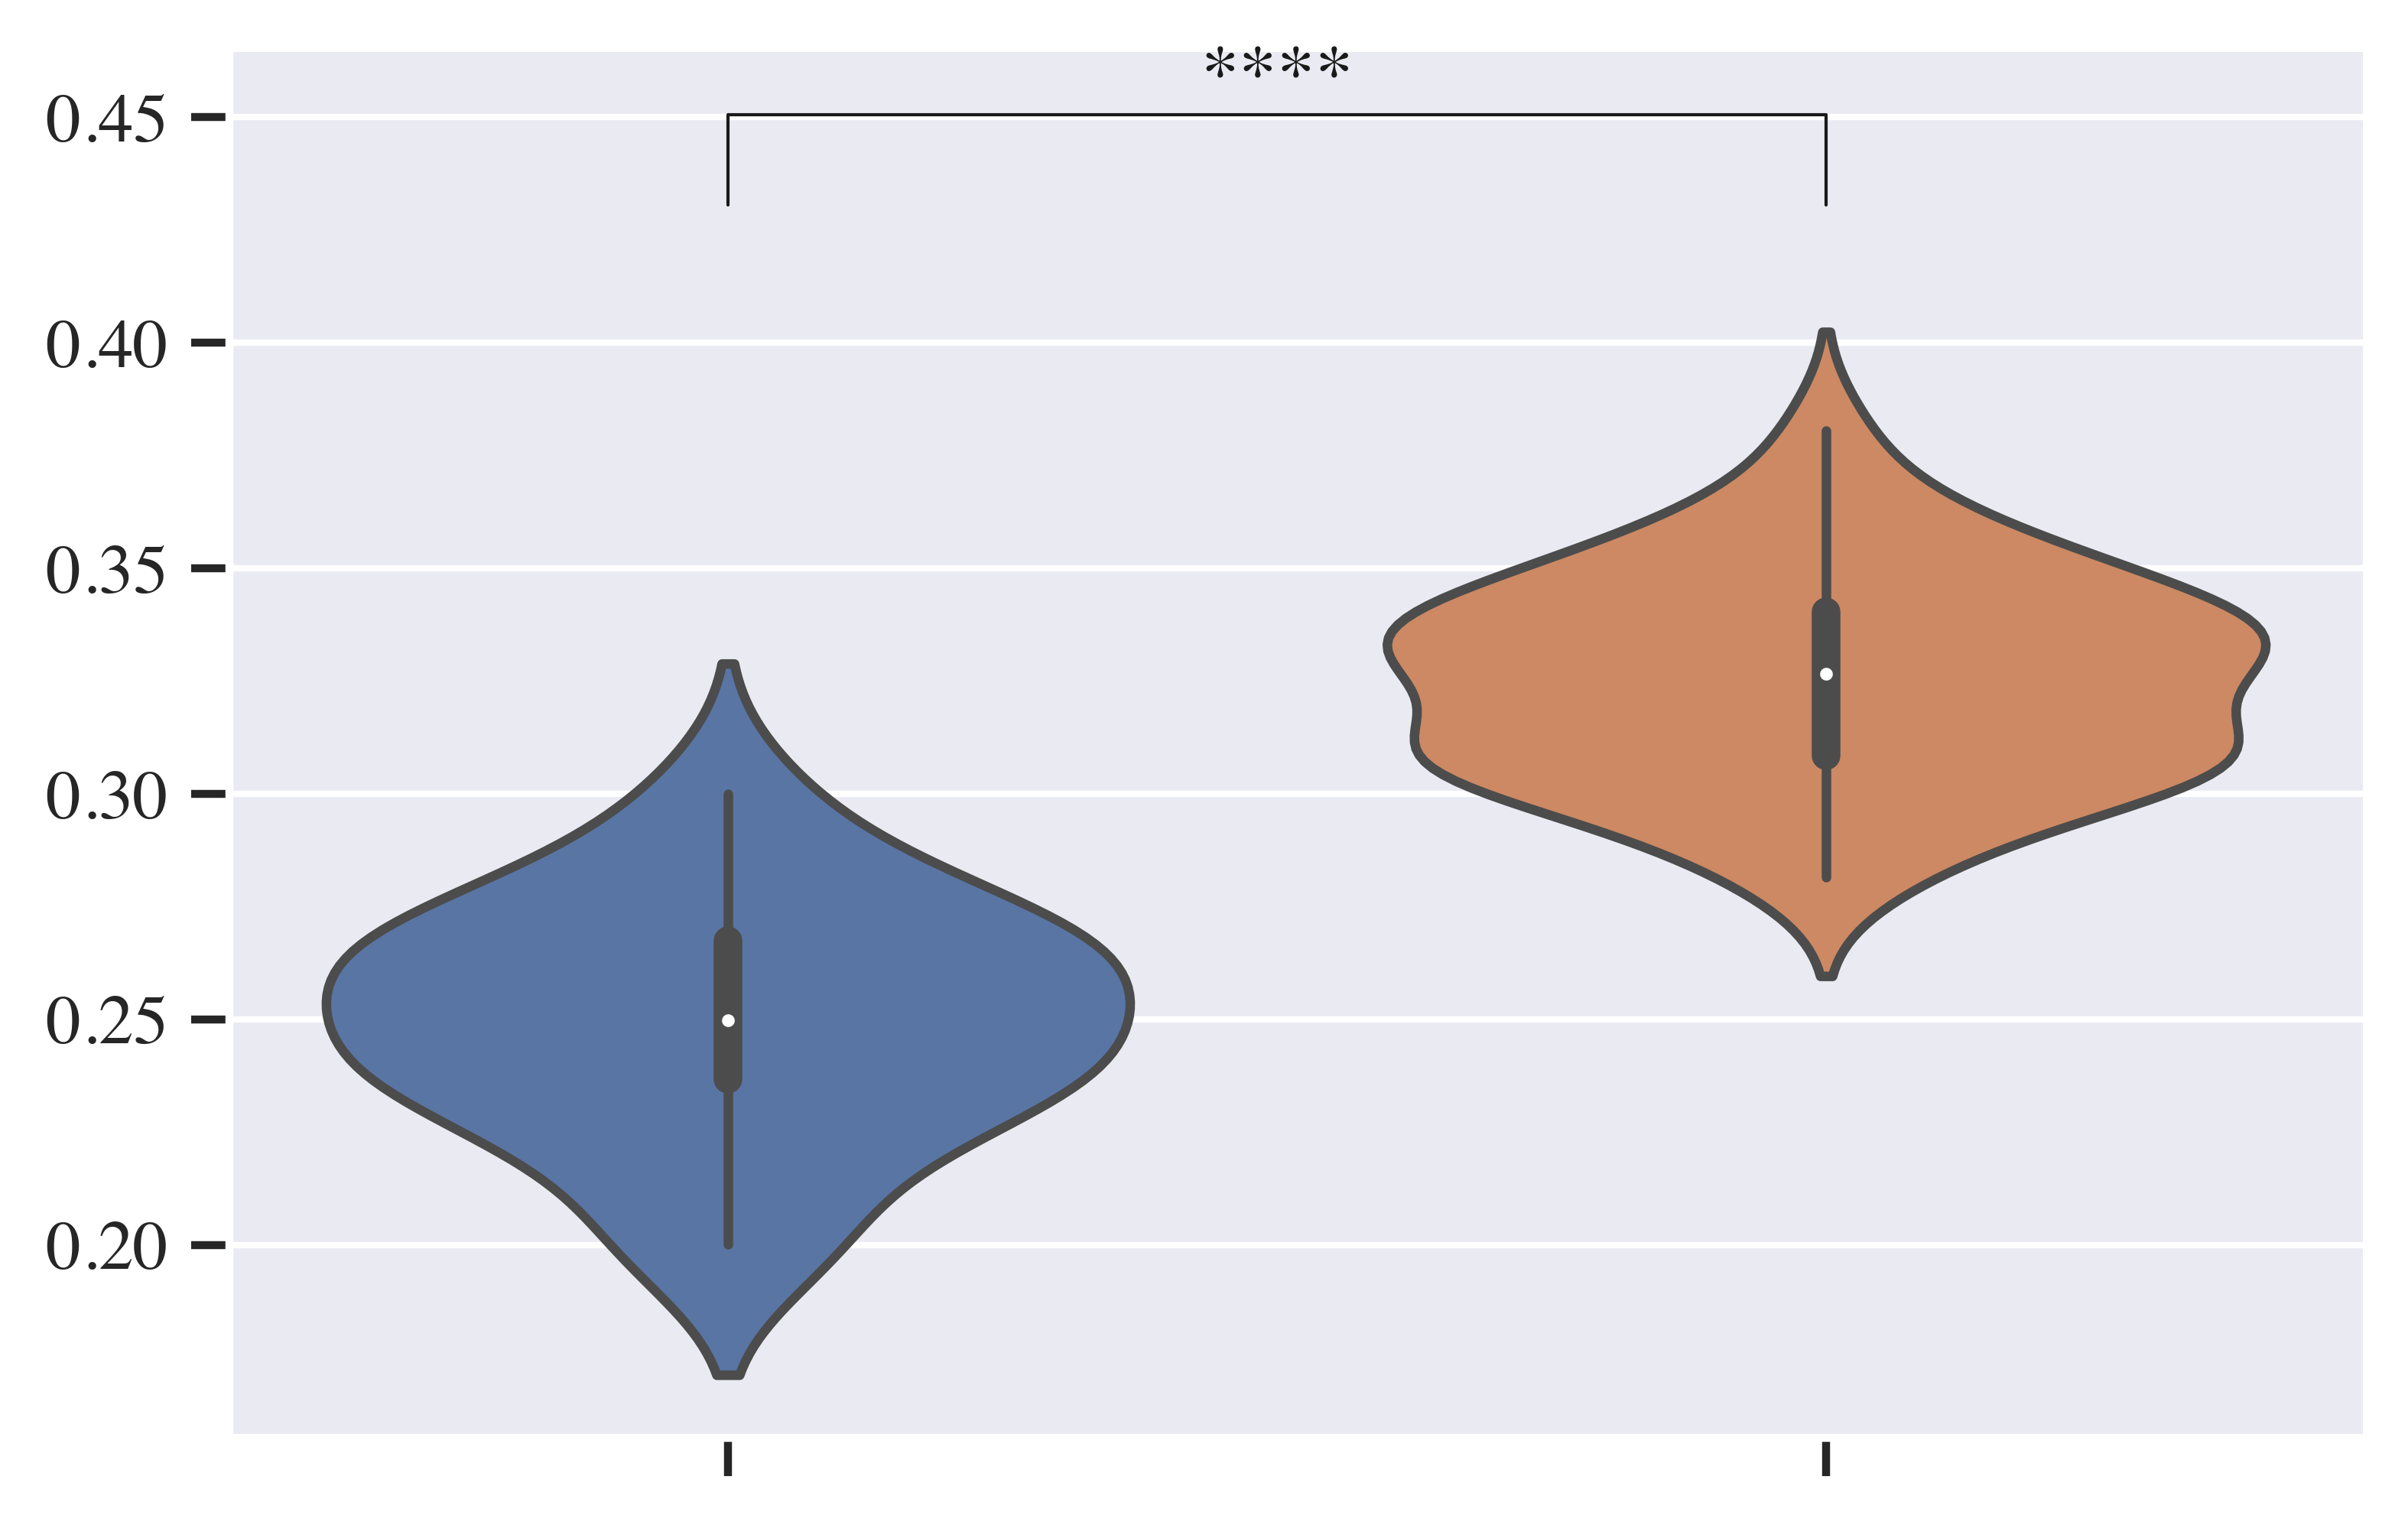

In [25]:
df = pd.DataFrame({'Type' : ['C']*20 + ['I']*40 ,
      'Synergy': list(DM1CtxDM1) + list(DM2CtxDM2) + list(DM1DM2) 
                   + list(DM1CtxDM2) + list(DM2CtxDM1) 
                    + list(CtxDM1CtxDM2),
        'Curriculum': [0]*20 + [1]*40,
        'Name' : ['Congruent']*20 + ['Incongruent']*40})

plt.figure(dpi=600)
sns.violinplot(data=df, x = 'Curriculum', y = 'Synergy')
plt.xticks(np.arange(0, 2, 1.0), np.array(['', '']))
plt.ylabel('')
plt.xlabel('')
plt.minorticks_off()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
x1, x2 = 0, 1
y, h, col = df['Synergy'].max() + 0.05, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, c=col)
plt.text((x1+x2)*.5, y+h, cong_incong_pval, ha='center', va='bottom', color=col)
# plt.savefig('PaperFigures-Draft5/R5-Fig6.pdf', bbox_inches='tight', transparent=True)
plt.show()